# Multitask RLVR using GRPO
### *HSE, "Data Science Specialist" Final Project*
Sukhotin Oleg, DS-19, 2026

**Цель проекта:** применить GRPO (Grouped Relative Policy Optimization) для дообучения модели **Qwen2.5-7B-Instruct** на задачах с *проверяемыми* ответами: математика, SQL, программирование (Python).

**Ключевая идея:** используем **rull-based reward-функции**, которые верифицируют ответ (парсинг, запуск тестов, выполнение SQL-запроса и т.п.).  
В результате получаем воспроизводимый пайплайн: *данные → предобработка → EDA → reward → обучение → валидация → результаты*.

Ноутбук интегрирован с сервисами Google Drive, tensorboard (website via ngrok), huggingface.


## 1. Окружение и зависимости

Ниже — минимальный сетап для Colab (или любой Linux-среды).  
Версии зафиксированы так же, как в экспериментальном окружении, чтобы результаты были воспроизводимы.


In [1]:
%%capture
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"
!pip install --upgrade -qqq uv
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    try: import numpy, PIL; get_numpy = f"numpy=={numpy.__version__}"; get_pil = f"pillow=={PIL.__version__}"
    except: get_numpy = "numpy"; get_pil = "pillow"
    try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
    except: is_t4 = False
    get_vllm, get_triton = ("vllm==0.9.2", "triton==3.2.0") if is_t4 else ("vllm==0.10.2", "triton")
    !uv pip install -qqq --upgrade \
        unsloth {get_vllm} {get_numpy} {get_pil} torchvision bitsandbytes xformers
    !uv pip install -qqq {get_triton}
!uv pip install transformers==4.56.2
!uv pip install --no-deps trl==0.22.2

In [2]:
try:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
except Exception:
    print("Google Colab не обнаружен — продолжаем без Drive.")


Mounted at /content/drive


In [ ]:
!pip -q install pyngrok
from pyngrok import ngrok
ngrok.set_auth_token("PLACE_YOUR_TOKEN_HERE")

## 2. Конфигурация проекта и воспроизводимость

Здесь задаются пути, seed и базовые настройки.  
Все артефакты (логи, eval-результаты, чекпоинты) сохраняются в `RUNS_DIR`.


In [3]:
from __future__ import annotations

import os
import random
import time
from pathlib import Path

import numpy as np

PROJECT_DIR = os.environ.get("PROJECT_DIR", "/content/drive/MyDrive/HSE GRPO")
DATASETS_DIR = f"{PROJECT_DIR}/datasets"
SPLITS_DIR = f"{PROJECT_DIR}/splits"
RUNS_DIR = f"{PROJECT_DIR}/runs"

Path(DATASETS_DIR).mkdir(parents=True, exist_ok=True)
Path(SPLITS_DIR).mkdir(parents=True, exist_ok=True)
Path(RUNS_DIR).mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

RUN_STAMP = time.strftime("%Y%m%d_%H%M%S")
print("PROJECT_DIR:", PROJECT_DIR)
print("RUNS_DIR:", RUNS_DIR)
print("SEED:", SEED)


PROJECT_DIR: /content/drive/MyDrive/HSE GRPO
RUNS_DIR: /content/drive/MyDrive/HSE GRPO/runs
SEED: 42


## 3. Модель и LoRA-конфигурация

Базовая модель: **unsloth/Qwen2.5-7B-Instruct-bnb-4bit**.  
Для обучения используем LoRA (PEFT) — это существенно экономит память и ускоряет итерации.


## Unsloth TRL Patch

<img src="https://miro.medium.com/v2/resize:fit:898/0*tporAgJg5LLllQe_.png" width=250>

Unsloth's `PatchFastRL` modifies TRL (Transformer Reinforcement Learning) trainers to work efficiently with Unsloth's optimized models. The patch makes three key changes:

1. Patches the model unwrapping process for efficient generation during training
2. Modifies TRL trainers with Unsloth-specific optimizations, including things like:
   - Automatically handles mixed precision training (FP16/BF16) based on model config
   - Sets optimal defaults for hyperparameters like learning rate, batch sizes, and gradient accumulation
   - Adds safety checks for learning rates and sequence lengths
   - Configures tokenizer padding and model inference settings
   - Integrates with vLLM for faster inference when available
   - And more!
3. Sets up algorithm-specific statistics tracking (in our case, for GRPO)

You can check out the implementation details [in their code here](https://github.com/unslothai/unsloth/blob/d1d15f1d14f1168837d29b9c08e9b6d63945d469/unsloth/models/rl.py).

In [4]:
from unsloth import FastLanguageModel, PatchFastRL

PatchFastRL("GRPO", FastLanguageModel)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 02-09 11:53:24 [__init__.py:216] Automatically detected platform cuda.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: UnslothAlignPropTrainer is already patched.
Unsloth: UnslothBCOTrainer is already patched.
Unsloth: UnslothCPOTrainer is already patched.
Unsloth: UnslothDDPOTrainer is already patched.
Unsloth: UnslothDPOTrainer is already patched.
Unsloth: UnslothGKDTrainer is already patched.
Unsloth: UnslothGRPOTrainer is already patched.
Unsloth: UnslothIterativeSFTTrainer is already patched.
Unsloth: UnslothKTOTrainer is already patched.
Unsloth: UnslothNashMDTrainer is already patched.
Unsloth: UnslothOnlineDPOTrainer is already patched.
Unsloth: UnslothORPOTrainer is already patched.
Unsloth: UnslothPPOTrainer is already patched.
Unsloth: UnslothPRMTrainer is already patched.
Unsloth: UnslothRewardTrainer is already patched.
Unsloth: UnslothRLOOTrainer is already patched.
Uns

In [5]:
# max_seq_length: должен покрывать prompt + completion.
# load_in_4bit: экономия VRAM.
# gpu_memory_utilization: ограничиваем, чтобы избежать OOM в Colab.

import torch

MODEL_NAME = "unsloth/qwen2.5-coder-7b-instruct-bnb-4bit"

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_NAME,
    max_seq_length=4096,
    load_in_4bit=True,
    fast_inference=True,
    max_lora_rank=64,
    gpu_memory_utilization=0.30,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=64,
    lora_alpha=64,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    use_gradient_checkpointing="unsloth",
    random_state=3407,
)

print("Loaded:", MODEL_NAME)


INFO 02-09 11:53:43 [vllm_utils.py:702] Unsloth: Patching vLLM v1 graph capture
INFO 02-09 11:53:43 [vllm_utils.py:731] Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.56.2. vLLM: 0.10.2.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-coder-7b-instruct-bnb-4bit with actual GPU utilization = 29.83%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 79.32 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 4096. Num Sequences = 80.
Unsloth: vLLM's KV Cache can use up to 17.53 GB. Also swap space = 6 GB.
Unsloth: Disabling `d

`torch_dtype` is deprecated! Use `dtype` instead!


INFO 02-09 11:54:13 [__init__.py:1815] Using max model len 4096
WARNING 02-09 11:54:13 [_ipex_ops.py:16] Import error msg: No module named 'intel_extension_for_pytorch'
INFO 02-09 11:54:17 [scheduler.py:222] Chunked prefill is enabled with max_num_batched_tokens=6144.
WARNING 02-09 11:54:17 [lora.py:92] `lora_extra_vocab_size` is deprecated and will be removed in v0.12.0. Additional vocabulary support for LoRA adapters is being phased out.
Unsloth: vLLM Bitsandbytes config using kwargs = {'load_in_8bit': False, 'load_in_4bit': True, 'bnb_4bit_compute_dtype': 'bfloat16', 'bnb_4bit_quant_storage': 'uint8', 'bnb_4bit_quant_type': 'nf4', 'bnb_4bit_use_double_quant': True, 'llm_int8_enable_fp32_cpu_offload': False, 'llm_int8_has_fp16_weight': False, 'llm_int8_skip_modules': [], 'llm_int8_threshold': 6.0}


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/265 [00:00<?, ?B/s]

INFO 02-09 11:54:22 [core.py:76] Initializing a V1 LLM engine (v0.10.2) with config: model='unsloth/qwen2.5-coder-7b-instruct-bnb-4bit', speculative_config=None, tokenizer='unsloth/qwen2.5-coder-7b-instruct-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=4096, download_dir=None, load_format=bitsandbytes, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=bitsandbytes, enforce_eager=False, kv_cache_dtype=auto, device_config=cuda, decoding_config=DecodingConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_backend=''), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=None), seed=0, served_model_name=unsloth/qwen2.5-coder-7b-instruct-bnb-4bit, enable_prefix_caching=

model.safetensors:   0%|          | 0.00/5.55G [00:00<?, ?B/s]

INFO 02-09 11:54:40 [weight_utils.py:369] Time spent downloading weights for unsloth/qwen2.5-coder-7b-instruct-bnb-4bit: 15.064394 seconds
INFO 02-09 11:54:41 [weight_utils.py:406] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 02-09 11:54:43 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 02-09 11:54:44 [gpu_model_runner.py:2392] Model loading took 5.5144 GiB and 19.147614 seconds
INFO 02-09 11:54:53 [gpu_worker.py:298] Available KV cache memory: 17.08 GiB
INFO 02-09 11:54:53 [kv_cache_utils.py:864] GPU KV cache size: 319,888 tokens
INFO 02-09 11:54:53 [kv_cache_utils.py:868] Maximum concurrency for 4,096 tokens per request: 78.10x
INFO 02-09 11:54:53 [vllm_utils.py:707] Unsloth: Running patched vLLM v1 `capture_model`.


Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 23/23 [00:15<00:00,  1.53it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]

INFO 02-09 11:55:12 [gpu_model_runner.py:3118] Graph capturing finished in 19 secs, took 0.53 GiB
INFO 02-09 11:55:12 [vllm_utils.py:714] Unsloth: Patched vLLM v1 graph capture finished in 19 secs.


INFO 02-09 11:55:14 [gpu_worker.py:391] Free memory on device (78.79/79.32 GiB) on startup. Desired GPU memory utilization is (0.2982864055145285, 23.66 GiB). Actual usage is 5.51 GiB for weight, 1.04 GiB for peak activation, 0.02 GiB for non-torch memory, and 0.53 GiB for CUDAGraph memory. Replace gpu_memory_utilization config with `--kv-cache-memory=17622779084` to fit into requested memory, or `--kv-cache-memory=76819625984` to fully utilize gpu memory. Current kv cache memory in use is 18344199372 bytes.
INFO 02-09 11:55:14 [core.py:218] init engine (profile, create kv cache, warmup model) took 29.87 seconds
INFO 02-09 11:55:15 [llm.py:295] Supported_tasks: ('generate',)
INFO 02-09 11:55:15 [__init__.py:36] No IOProcessor plugins requested by the model
Unsloth: Just some info: will skip parsing ['norm', 'k_norm', 'input_layernorm', 'ffn_norm', 'norm2', 'layer_norm1', 'pre_feedforward_layernorm', 'attention_norm', 'q_norm', 'norm1', 'post_feedforward_layernorm', 'post_attention_laye

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Unsloth 2026.1.4 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


Loaded: unsloth/qwen2.5-coder-7b-instruct-bnb-4bit


## 4. Данные: источники, формат, промпты

Все задачи приводятся к единому формату для TRL/GRPO:

- `prompt`: список сообщений (system/user) в стиле chat-template
- `task`: строка (`sql` | `math` | `sudoku` | `code` | `ioi`)
- `solution`: золотой ответ (строка)
- `references`: JSON-строка с доп.информацией для reward (тесты, контекст, метаданные)

**Важно:** `references` всегда строка. Это критично для безопасной конкатенации датасетов.


In [6]:
import json
import re
from typing import Any, Dict, List, Optional

from datasets import Dataset

SYSTEM_PROMPT = (
    """
    You are a helpful assistant.

    You MUST answer in exactly this structure (no text outside these tags):

    <reasoning>
    ...your step-by-step reasoning...
    </reasoning>
    <answer>
    ...final output only (see task-specific rules)...
    </answer>

    HARD REQUIREMENTS (apply to ALL tasks):
    - <reasoning> is REQUIRED AND MUST be CLOSED with </reasoning>. Do not omit it.
    - <answer> is REQUIRED AND MUST be CLOSED with </answer>.
    - Do not output anything before <reasoning> or after </answer>.
    - Do not use extra wrapper tags besides <reasoning> and <answer>.

    Task-specific rules (content inside <answer>):
    - SQL: output ONLY ONE SQL query. No explanation, no markdown/code fences.
    - MATH: output ONLY the final result (no extra text).
    - CODE (Python): output ONLY ONE fenced code block:
        ```python
        ...
        ```
      Nothing else inside <answer>. Read only with sys.stdin.read(), write only in stdout.
    """
)

def ref_json(obj: Any) -> str:
    """Serialize references into a JSON string (stable schema for concatenation)."""
    try:
        return json.dumps(obj, ensure_ascii=False, default=str)
    except Exception:
        return json.dumps(str(obj), ensure_ascii=False)


def read_jsonl(path: str, limit: int = 0) -> List[Dict[str, Any]]:
    rows: List[Dict[str, Any]] = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            rows.append(json.loads(line))
            if limit and len(rows) >= limit:
                break
    return rows


def sql_key(ex: Dict[str, Any]) -> tuple[str, str, str]:
    return (ex["sql_prompt"].strip(), ex["sql_context"].strip(), ex["sql"].strip())


def validate_grpo_dataset(ds: Dataset, expected_task: Optional[str] = None, n_check: int = 50) -> None:
    """Hard validation of GRPO dataset schema. Raises on mismatch."""
    required = {"prompt", "task", "solution", "references"}
    cols = set(ds.column_names)
    missing = required - cols
    if missing:
        raise ValueError(f"Dataset missing columns {missing}. Has: {ds.column_names}")

    n = min(len(ds), n_check)
    for i in range(n):
        ex = ds[i]
        if expected_task is not None and ex["task"] != expected_task:
            raise ValueError(f"Row {i}: task={ex['task']} but expected {expected_task}")

        if not isinstance(ex["solution"], str):
            raise TypeError(f"Row {i}: solution must be str, got {type(ex['solution'])}")

        if not isinstance(ex["references"], str):
            raise TypeError(f"Row {i}: references must be str, got {type(ex['references'])}")

        p = ex["prompt"]
        if not isinstance(p, list) or not p:
            raise TypeError(f"Row {i}: prompt must be non-empty list, got {type(p)}")
        for j, msg in enumerate(p):
            if not isinstance(msg, dict):
                raise TypeError(f"Row {i} msg {j}: must be dict, got {type(msg)}")
            if "role" not in msg or "content" not in msg:
                raise ValueError(f"Row {i} msg {j}: missing role/content keys")
            if not isinstance(msg["role"], str) or not isinstance(msg["content"], str):
                raise TypeError(f"Row {i} msg {j}: role/content must be str")

    print(
        f"✅ validate_grpo_dataset OK: rows={len(ds)} cols={ds.column_names} task={expected_task or 'mixed'}"
    )


### 4.1 Построение примеров для каждой задачи

Функции `build_*_samples` приводят разные датасеты к единому формату.


In [7]:
from datasets import load_dataset


def build_sql_samples(sql_rows: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    samples: List[Dict[str, Any]] = []
    for ex in sql_rows:
        sql_prompt = ex["sql_prompt"]
        sql_context = ex["sql_context"]
        gold_sql = ex["sql"]

        samples.append(
            {
                "prompt": [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {
                        "role": "user",
                        "content": "TASK: SQL\n" + f"{sql_context}\n\nQuestion: {sql_prompt}",
                    },
                ],
                "task": "sql",
                "solution": gold_sql,
                "references": ref_json(
                    {
                        "sql_prompt": sql_prompt,
                        "sql_context": sql_context,
                        "gold_sql": gold_sql,
                    }
                ),
            }
        )
    return samples


def build_math_samples(math_ds, limit: int = 0) -> List[Dict[str, Any]]:
    samples: List[Dict[str, Any]] = []
    for i, ex in enumerate(math_ds):
        problem = ex["prompt"]
        gold_answer = ex["solution"]
        samples.append(
            {
                "prompt": [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": "TASK: MATH\n\n" + problem},
                ],
                "task": "math",
                "solution": gold_answer,
                "references": "",
            }
        )
        if limit and (i + 1) >= limit:
            break
    return samples


def build_code_samples(code_ds, limit: int = 0) -> List[Dict[str, Any]]:
    samples: List[Dict[str, Any]] = []
    for i, ex in enumerate(code_ds):
        statement = ex.get("problem_statement") or ex.get("prompt") or ex.get("question") or ""
        verification_info = ex.get("verification_info") or {}
        pid = ex.get("id") or ex.get("problem_id") or ex.get("slug") or ex.get("name") or ""

        gold = ex.get("solution") or ex.get("gold_solution") or ex.get("reference_solution") or ex.get("answer") or ""

        samples.append(
            {
                "prompt": [
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {"role": "user", "content": "TASK: CODE\n\n" + str(statement).strip()},
                ],
                "task": "code",
                "solution": str(gold) if gold is not None else "",
                "references": ref_json({"id": pid, "verification_info": verification_info}),
            }
        )
        if limit and (i + 1) >= limit:
            break
    return samples


### 4.2 Детерминированные сплиты для OpenR1-Math (one-time)

Чтобы сравнения baseline/post-train были корректными, фиксируем eval-набор через сохранённые индексы.


In [8]:
import json
from pathlib import Path

MATH_CONFIG = "level_3"
MATH_DATASET = "open-r1/Big-Math-RL-Verified-Processed"
MATH_EVAL_N = 1000

math_train_split_file = Path(SPLITS_DIR) / f"openr1_math_{MATH_CONFIG}_train_seed{SEED}.json"
math_eval_split_file = Path(SPLITS_DIR) / f"openr1_math_{MATH_CONFIG}_eval_{MATH_EVAL_N}_seed{SEED}.json"

if not (math_train_split_file.exists() and math_eval_split_file.exists()):
    ds = load_dataset(MATH_DATASET, MATH_CONFIG, split="train")
    n = len(ds)

    rng = np.random.default_rng(SEED)
    perm = rng.permutation(n).tolist()

    eval_n = min(MATH_EVAL_N, n)
    eval_idx = perm[:eval_n]
    train_idx = perm[eval_n:]

    math_train_split_file.write_text(json.dumps({"train_indices": train_idx}, ensure_ascii=False), encoding="utf-8")
    math_eval_split_file.write_text(json.dumps({"eval_indices": eval_idx}, ensure_ascii=False), encoding="utf-8")

    print("✅ Saved split files:")
    print("-", math_train_split_file)
    print("-", math_eval_split_file)
else:
    print("Split files already exist:")
    print("-", math_train_split_file)
    print("-", math_eval_split_file)


Split files already exist:
- /content/drive/MyDrive/HSE GRPO/splits/openr1_math_level_3_train_seed42.json
- /content/drive/MyDrive/HSE GRPO/splits/openr1_math_level_3_eval_1000_seed42.json


### 4.3 Сборка train/eval датасетов

- SQL берём из локальных JSONL (предполагается, что вы уже подготовили LLM-generated dataset).
- Остальные задачи — напрямую из HuggingFace Datasets.
- Для SQL дополнительно фильтруем пересечение train/eval (избегаем утечек).


In [10]:
from pathlib import Path

from datasets import concatenate_datasets, interleave_datasets

ENABLE_SQL = True
ENABLE_MATH = True
ENABLE_CODE = True

SQL_TRAIN_JSONL_PATH = f"{DATASETS_DIR}/cleaned_train_queries.jsonl.example"
SQL_EVAL_JSONL_PATH = f"{DATASETS_DIR}/cleaned_eval_queries.jsonl.example"

SQL_TRAIN_LIMIT = 900
MATH_TRAIN_LIMIT = 900
CODE_TRAIN_LIMIT = 900

SQL_EVAL_FULL_N = 1000
SQL_EVAL_BASELINE_N = 200
MATH_EVAL_BASELINE_N = 200
CODE_EVAL_FULL_N = 500
CODE_EVAL_BASELINE_N = 200


def empty_grpo_ds() -> Dataset:
    return Dataset.from_dict({"prompt": [], "task": [], "solution": [], "references": []})


train_parts = []
sql_train_grpo_ds = empty_grpo_ds()
math_train_grpo_ds = empty_grpo_ds()
code_train_grpo_ds = empty_grpo_ds()

if ENABLE_SQL:
    if not (Path(SQL_TRAIN_JSONL_PATH).exists() and Path(SQL_EVAL_JSONL_PATH).exists()):
        raise FileNotFoundError(
            "Не найдены SQL jsonl файлы. Ожидается:\n"
            f"- {SQL_TRAIN_JSONL_PATH}\n- {SQL_EVAL_JSONL_PATH}"
        )

    sql_train_rows = read_jsonl(SQL_TRAIN_JSONL_PATH, limit=SQL_TRAIN_LIMIT)
    sql_eval_rows_for_filter = read_jsonl(SQL_EVAL_JSONL_PATH, limit=0)

    eval_keys = set(sql_key(x) for x in sql_eval_rows_for_filter)
    before = len(sql_train_rows)
    sql_train_rows = [x for x in sql_train_rows if sql_key(x) not in eval_keys]
    after = len(sql_train_rows)

    print(f"SQL train overlap filtered: {before} -> {after}")
    sql_train_grpo_ds = Dataset.from_list(build_sql_samples(sql_train_rows))
    validate_grpo_dataset(sql_train_grpo_ds, expected_task="sql")
    train_parts.append(sql_train_grpo_ds)

if ENABLE_MATH:
    train_idx = json.loads(Path(math_train_split_file).read_text(encoding="utf-8"))["train_indices"]
    math_raw_ds = load_dataset(MATH_DATASET, MATH_CONFIG, split="train").select(train_idx)
    if MATH_TRAIN_LIMIT and MATH_TRAIN_LIMIT < len(math_raw_ds):
        math_raw_ds = math_raw_ds.select(range(MATH_TRAIN_LIMIT))
    math_train_grpo_ds = Dataset.from_list(build_math_samples(math_raw_ds))
    validate_grpo_dataset(math_train_grpo_ds, expected_task="math")
    train_parts.append(math_train_grpo_ds)

if ENABLE_CODE:
    code_raw_ds = load_dataset("open-r1/verifiable-coding-problems-python", split="train")
    if CODE_TRAIN_LIMIT and CODE_TRAIN_LIMIT < len(code_raw_ds):
        code_raw_ds = code_raw_ds.select(range(CODE_TRAIN_LIMIT))
    code_train_grpo_ds = Dataset.from_list(build_code_samples(code_raw_ds))
    validate_grpo_dataset(code_train_grpo_ds, expected_task="code")
    train_parts.append(code_train_grpo_ds)

if not train_parts:
    raise RuntimeError("Не включена ни одна задача — train_parts пустой.")

parts_shuffled = [d.shuffle(seed=SEED) for d in train_parts]
probs = [1.0 / len(parts_shuffled)] * len(parts_shuffled)
train_dataset = interleave_datasets(
    parts_shuffled,
    probabilities=probs,
    seed=SEED,
    stopping_strategy="all_exhausted",
)

print("\n✅ TRAIN ready")
for d in parts_shuffled:
    print("-", d[0]["task"], "size:", len(d))
print("mixed train size:", len(train_dataset))


# --- EVAL datasets ---
sql_eval_samples_full = []
sql_eval_samples_baseline = []
math_eval_samples_full = []
math_eval_samples_baseline = []
code_eval_samples_full = []
code_eval_samples_baseline = []

if ENABLE_SQL:
    sql_eval_rows_full = read_jsonl(SQL_EVAL_JSONL_PATH, limit=SQL_EVAL_FULL_N)
    sql_eval_rows_baseline = sql_eval_rows_full[:SQL_EVAL_BASELINE_N]
    sql_eval_samples_full = build_sql_samples(sql_eval_rows_full)
    sql_eval_samples_baseline = build_sql_samples(sql_eval_rows_baseline)

if ENABLE_MATH:
    eval_idx = json.loads(Path(math_eval_split_file).read_text(encoding="utf-8"))["eval_indices"]
    math_eval_full_raw = load_dataset(MATH_DATASET, MATH_CONFIG, split="train").select(eval_idx)
    math_eval_baseline_raw = math_eval_full_raw.select(range(min(MATH_EVAL_BASELINE_N, len(math_eval_full_raw))))
    math_eval_samples_full = build_math_samples(math_eval_full_raw)
    math_eval_samples_baseline = build_math_samples(math_eval_baseline_raw)

if ENABLE_CODE:
    code_eval_raw = load_dataset("open-r1/verifiable-coding-problems-python", split="train")
    code_eval_full_raw = code_eval_raw.select(range(min(CODE_EVAL_FULL_N, len(code_eval_raw))))
    code_eval_baseline_raw = code_eval_full_raw.select(range(min(CODE_EVAL_BASELINE_N, len(code_eval_full_raw))))
    code_eval_samples_full = build_code_samples(code_eval_full_raw)
    code_eval_samples_baseline = build_code_samples(code_eval_baseline_raw)

eval_dataset_full = Dataset.from_list(
    sql_eval_samples_full
    + math_eval_samples_full
    + code_eval_samples_full
)

eval_dataset_baseline = Dataset.from_list(
    sql_eval_samples_baseline
    + math_eval_samples_baseline
    + code_eval_samples_baseline
)

print("\n✅ EVAL ready")
print("Eval baseline total:", len(eval_dataset_baseline))
print("Eval full total:", len(eval_dataset_full))


SQL train overlap filtered: 900 -> 900
✅ validate_grpo_dataset OK: rows=900 cols=['prompt', 'task', 'solution', 'references'] task=sql


README.md: 0.00B [00:00, ?B/s]

level_3/train-00000-of-00001.parquet:   0%|          | 0.00/5.61M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/42501 [00:00<?, ? examples/s]

✅ validate_grpo_dataset OK: rows=900 cols=['prompt', 'task', 'solution', 'references'] task=math


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00011.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

data/train-00001-of-00011.parquet:   0%|          | 0.00/398M [00:00<?, ?B/s]

data/train-00002-of-00011.parquet:   0%|          | 0.00/138M [00:00<?, ?B/s]

data/train-00003-of-00011.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

data/train-00004-of-00011.parquet:   0%|          | 0.00/128M [00:00<?, ?B/s]

data/train-00005-of-00011.parquet:   0%|          | 0.00/121M [00:00<?, ?B/s]

data/train-00006-of-00011.parquet:   0%|          | 0.00/388M [00:00<?, ?B/s]

data/train-00007-of-00011.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

data/train-00008-of-00011.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

data/train-00009-of-00011.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

data/train-00010-of-00011.parquet:   0%|          | 0.00/325M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/35735 [00:00<?, ? examples/s]

✅ validate_grpo_dataset OK: rows=900 cols=['prompt', 'task', 'solution', 'references'] task=code

✅ TRAIN ready
- sql size: 900
- math size: 900
- code size: 900
mixed train size: 2708

✅ EVAL ready
Eval baseline total: 500
Eval full total: 1600


## 5. EDA: быстрые sanity-проверки датасетов

Ключевые аспекты EDA для RL-задач:

- размеры поднаборов по задачам;
- длина prompt’ов (в токенах) → влияет на `max_prompt_length` и VRAM;
- несколько примеров для ручной проверки формата.

Ниже — сводка по длинам prompt’ов на небольшом сэмпле.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt


def prompt_to_text(prompt_messages: List[Dict[str, str]]) -> str:
    return tokenizer.apply_chat_template(prompt_messages, tokenize=False, add_generation_prompt=True)


def summarize_ds(ds: Dataset, name: str, sample_n: int = 200) -> Dict[str, Any]:
    n = len(ds)
    m = min(sample_n, n)
    texts = [prompt_to_text(ds[i]["prompt"]) for i in range(m)]
    tok_lens = [len(tokenizer(t).input_ids) for t in texts]
    char_lens = [len(t) for t in texts]
    return {
        "task": name,
        "n_rows": n,
        "sample_n": m,
        "prompt_tokens_mean": float(np.mean(tok_lens)) if tok_lens else 0.0,
        "prompt_tokens_p95": float(np.quantile(tok_lens, 0.95)) if tok_lens else 0.0,
        "prompt_chars_mean": float(np.mean(char_lens)) if char_lens else 0.0,
    }


rows = []
for ds_name, ds_obj in [
    ("sql_train", sql_train_grpo_ds),
    ("math_train", math_train_grpo_ds),
    ("code_train", code_train_grpo_ds),
]:
    if len(ds_obj) > 0:
        rows.append(summarize_ds(ds_obj, ds_name))

summary_df = pd.DataFrame(rows).sort_values("n_rows", ascending=False)
summary_df


,task,n_rows,sample_n,prompt_tokens_mean,prompt_tokens_p95,prompt_chars_mean
0,sql_train,900,200,350.825,445.15,1430.055
1,math_train,900,200,301.590,351.60,1268.870
2,code_train,900,200,882.620,1310.80,3262.245


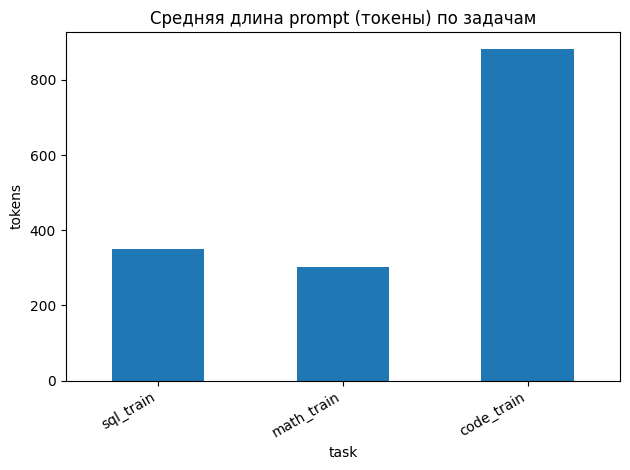

In [12]:
if not summary_df.empty:
    ax = summary_df.plot(kind="bar", x="task", y="prompt_tokens_mean", legend=False)
    ax.set_title("Средняя длина prompt (токены) по задачам")
    ax.set_ylabel("tokens")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


Примеры (по одному) — полезны для ручной проверки структуры prompt и полей `references/solution`.


In [13]:
def show_example(ds: Dataset, i: int = 0) -> None:
    ex = ds[i]
    print("task:", ex["task"])
    sol = ex["solution"]
    ref = ex["references"]
    print("solution head:", (sol[:120] + "...") if len(sol) > 120 else sol)
    print("references head:", (ref[:160] + "...") if len(ref) > 160 else ref)
    print("\n--- prompt (last user) ---")
    print(ex["prompt"][-1]["content"][:800])


for name, ds in [
    ("sql", sql_train_grpo_ds),
    ("math", math_train_grpo_ds),
    ("code", code_train_grpo_ds),
]:
    if len(ds) > 0:
        print("\n====================", name, "====================")
        show_example(ds, 0)



==================== sql ====================
task: sql
solution head: SELECT name, capacity FROM wind_farms WHERE country = 'USA'
references head: {"sql_prompt": "What are the names and capacities of all wind farms in the USA?", "sql_context": "CREATE TABLE wind_farms (name TEXT, capacity INTEGER, country ...

--- prompt (last user) ---
TASK: SQL
CREATE TABLE wind_farms (name TEXT, capacity INTEGER, country TEXT); INSERT INTO wind_farms (name, capacity, country) VALUES ('Wind Farm 1', 100, 'USA'), ('Wind Farm 2', 200, 'USA');

Question: What are the names and capacities of all wind farms in the USA?

==================== math ====================
task: math
solution head: 9
references head: 

--- prompt (last user) ---
TASK: MATH

The temperature $3^{\circ}\mathrm{C}$ is ____ $^{\circ}\mathrm{C}$ higher than $-6^{\circ}\mathrm{C}$.

==================== code ====================
task: code
solution head: 
references head: {"id": "vfc_0", "verification_info": {"language": "python", "t

## 6. Reward-функции (verifiable)

Компоненты reward:

- **Format reward** (строгая разметка `<reasoning>...</reasoning><answer>...</answer>`, а для code — fenced code block).
- **Task-specific reward**:
  - **Math**: `math_verify` (парсинг LaTeX/выражений и проверка эквивалентности).
  - **SQL**: парсинг/нормализация + выполнение запросов (execution-based reward).
  - **Code (Python)**: запуск тестов из `verification_info`.


In [14]:
import re
from typing import Any

def completion_to_text(completion: Any) -> str:
    if completion is None:
        return ""
    if isinstance(completion, str):
        return completion
    if isinstance(completion, dict):
        return completion.get("content") or completion.get("generated_text") or completion.get("text") or ""
    if isinstance(completion, list) and completion:
        return completion_to_text(completion[0])
    return str(completion)

_get_completion_text = completion_to_text
_comp_to_text = completion_to_text

_OPEN_RE = re.compile(r"<answer\s*>", re.IGNORECASE)
_CLOSE_RE = re.compile(r"</answer\s*>", re.IGNORECASE)

def extract_answer(text: str) -> str:
    if not text:
        return ""
    m_open = _OPEN_RE.search(text)
    if not m_open:
        return ""
    rest = text[m_open.end():]
    m_close = _CLOSE_RE.search(rest)
    return (rest[: m_close.start()] if m_close else rest).strip()


### 6.1 SQL rewards

Reward основан на:
- извлечении SQL из `<answer>...</answer>`;
- нормализации (sqlglot);
- попытке выполнения запроса на базе и оценке результата;
- эвристике сложности/качества reasoning.

Код ниже самодостаточный и используется как зависимость для mixed-обучения.


In [15]:
import sqlglot
from sqlglot import exp
import re
import os
import tempfile
import sqlite3
import logging
import sqlparse
import torch
import copy
import sqlglot
from sqlglot import parse as sqlglot_parse
from sqlglot import transpile as sqlglot_transpile
from sqlglot.errors import ParseError as SQLGlotParseError
from sqlglot.expressions import Column
from sqlglot.expressions import Column, Table
from typing import List, Dict, Tuple, Any, Optional, Set, Union
from sqlglot import transpile
from sqlglot.errors import ParseError



import json


def _ref_to_dict(ref) -> dict:
    """Normalize a single references item to dict.

    After dataset concatenation we store references as a JSON string for ALL tasks.
    This helper keeps backward-compatibility with legacy list/dict formats.
    """
    try:
        if ref is None:
            return {}
        if isinstance(ref, str):
            s = ref.strip()
            if not s:
                return {}
            try:
                v = json.loads(s)
                return v if isinstance(v, dict) else {}
            except Exception:
                return {}
        if isinstance(ref, dict):
            return ref
        if isinstance(ref, list) and ref:
            x = ref[0]
            if isinstance(x, dict):
                return x
            if isinstance(x, str):
                try:
                    v = json.loads(x)
                    return v if isinstance(v, dict) else {}
                except Exception:
                    return {}
        return {}
    except Exception:
        return {}


def _sql_ref(references, i: int) -> dict:
    try:
        if references is None or i >= len(references):
            return {}
        return _ref_to_dict(references[i])
    except Exception:
        return {}

log_level = logging.DEBUG if os.environ.get(
    "SQL_DEBUG_MODE") == "1" else logging.CRITICAL + 1
logging.basicConfig(
    level=log_level,
    format='%(asctime)s - %(levelname)s - %(name)s - %(filename)s:%(lineno)d - %(message)s'
)
logger = logging.getLogger(__name__)

REWARD_WEIGHTS = {
    "sql_correctness": 1.0,
    "complexity": 0.6,
    "reasoning": 0.7,
}

DEBUG_MODE = os.environ.get("SQL_DEBUG_MODE") == "1"

ERR_SYNTAX = "syntax_error"
ERR_MISSING_TABLE = "missing_table"
ERR_MISSING_COLUMN = "missing_column"
ERR_AMBIGUOUS_COLUMN = "ambiguous_column"
ERR_TYPE_MISMATCH = "type_mismatch"
ERR_CONSTRAINT = "constraint_violation"
ERR_FUNCTION = "function_error"
ERR_RESOURCE = "resource_error"
ERR_OTHER = "other_error"
ERR_SCHEMA_SETUP = "schema_setup_error"
ERR_CONVERSION = "sql_conversion_error"
ERR_EXECUTION = "sql_execution_error"
ERR_SCHEMA_VALIDATION = "schema_validation_error"


def _select_signature_ignore_aliases(sql: str) -> list[str]:
    """
    Возвращает канонический список выражений в SELECT, игнорируя алиасы:
    SELECT a AS x, b AS y  -> ["a", "b"]
    Плюс старается нормализовать table-alias -> table-name (u.id == users.id).
    """
    if not sql:
        return []

    try:
        tree = sqlglot.parse_one(sql, read="sqlite")
    except Exception:
        return []

    # alias таблиц:  users u  ->  u -> users
    table_alias_map = {}
    try:
        for t in tree.find_all(exp.Table):
            alias = t.alias
            if alias and alias != t.name:
                table_alias_map[alias] = t.name
    except Exception:
        pass

    sel = tree.find(exp.Select) if not isinstance(tree, exp.Select) else tree
    if not sel:
        return []

    signature = []
    for proj in sel.expressions:
        expr0 = proj.this if isinstance(proj, exp.Alias) else proj

        # копия, чтобы безопасно править
        try:
            expr1 = expr0.copy()
        except Exception:
            expr1 = expr0

        # нормализуем table alias в колонках: u.id -> users.id
        try:
            for col in expr1.find_all(exp.Column):
                if col.table and col.table in table_alias_map:
                    # table — это строка-идентификатор в sqlglot Column
                    col.args["table"] = exp.Identifier(this=table_alias_map[col.table])
        except Exception:
            pass

        # канонизируем выражение в строку
        try:
            signature.append(expr1.sql(dialect="sqlite", normalize=True).lower())
        except Exception:
            signature.append(str(expr1).lower())

    return signature


def _match_positions_by_signature(gold_sig: list[str], gen_sig: list[str]) -> list[tuple[int, int]]:
    used = set()
    sig_to_gen = {}
    for j, s in enumerate(gen_sig):
        sig_to_gen.setdefault(s, []).append(j)

    pairs = []
    for i, s in enumerate(gold_sig):
        for j in sig_to_gen.get(s, []):
            if j not in used:
                used.add(j)
                pairs.append((i, j))
                break
    return pairs

def _get_response_text(completion: Any) -> str:
    response_text = ""
    if isinstance(completion, str):
        response_text = completion
    elif isinstance(completion, list) and completion:
        if isinstance(completion[0], dict):
            response_text = completion[0].get(
                'content', completion[0].get('generated_text', ''))
        elif isinstance(completion[0], str):
            response_text = completion[0]
    elif isinstance(completion, dict):
        response_text = completion.get(
            'content', completion.get('generated_text', ''))
    else:
        try:
            response_text = str(completion)
        except Exception:
            response_text = ""
            logger.debug(
                "Could not convert completion to string: %s", type(completion))
    return response_text

def extract_sql(text: str) -> str:
    if not text:
        return ""

    # Логика для <answer>
    if "<answer>" in text:
        # Берем всё, что после открывающего тега
        sql = text.split("<answer>", 1)[1]

        # Если есть закрывающий тег, обрезаем по нему
        if "</answer>" in sql:
            sql = sql.split("</answer>", 1)[0]

        # Очистка от комментариев (инлайн, без отдельной функции)
        sql = re.sub(r"^\s*--.*?$", "", sql, flags=re.MULTILINE)
        sql = re.sub(r"/\*.*?\*/", "", sql, flags=re.DOTALL)
        return sql.strip()

    # Fallback метод (если тегов нет)
    sql_keywords = [r"\bSELECT\b", r"\bINSERT\b", r"\bUPDATE\b",
                    r"\bDELETE\b", r"\bCREATE\b", r"\bALTER\b", r"\bDROP\b"]

    text_upper = text.upper()
    sql_start_index = -1

    for keyword in sql_keywords:
        match = re.search(keyword, text_upper)
        if match:
            idx = match.start()
            if sql_start_index == -1 or idx < sql_start_index:
                sql_start_index = idx

    if sql_start_index != -1:
        potential_sql = text[sql_start_index:]

        # Обрезаем лишнее, если попалось
        potential_sql = potential_sql.split("</reasoning>", 1)[0]

        if ";" in potential_sql:
            potential_sql = potential_sql.split(";", 1)[0] + ";"

        # Очистка от комментариев
        potential_sql = re.sub(r"^\s*--.*?$", "", potential_sql, flags=re.MULTILINE)
        potential_sql = re.sub(r"/\*.*?\*/", "", potential_sql, flags=re.DOTALL)

        logger.debug("Extracted SQL using fallback method.")
        return potential_sql.strip()

    logger.debug("Could not extract SQL.")
    return ""


def extract_reasoning(text: str) -> str:
    if not text:
        return ""
    match = re.search(r"<reasoning>(.*?)</reasoning>",
                      text, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else ""


def calculate_sql_complexity(sql: str) -> float:
    if not sql:
        return 0.0
    try:
        sql_upper = sql.upper()
        score = 1.0
        score += sql_upper.count(" JOIN ") * 0.6
        score += sql_upper.count(" UNION ") * 0.8 + sql_upper.count(
            " INTERSECT ") * 0.8 + sql_upper.count(" EXCEPT ") * 0.8
        score += sql_upper.count("(SELECT") * 1.0
        score += sql_upper.count(" WITH ") * 0.8
        if " WHERE " in sql_upper:
            score += 0.2
        if " GROUP BY " in sql_upper:
            score += 0.5
        if " HAVING " in sql_upper:
            score += 0.7
        if " ORDER BY " in sql_upper:
            score += 0.3
        if " LIMIT " in sql_upper:
            score += 0.1
        agg_functions = ["COUNT(", "SUM(", "AVG(", "MAX(", "MIN("]
        score += sum(sql_upper.count(agg) for agg in agg_functions) * 0.3
        score += sql_upper.count(" DISTINCT ") * 0.3
        score += sql_upper.count(" CASE ") * 0.4
        score += sql_upper.count(" OVER(") * 1.0
        where_match = re.search(
            r" WHERE (.*?)(?: GROUP BY | ORDER BY | LIMIT | OFFSET |$)", sql_upper, re.DOTALL)
        if where_match:
            where_clause = where_match.group(1)
            score += where_clause.count(" AND ") * \
                0.15 + where_clause.count(" OR ") * 0.20
            score += where_clause.count(" IN ") * \
                0.2 + where_clause.count(" LIKE ") * 0.1
            score += where_clause.count(" BETWEEN ") * \
                0.2 + where_clause.count(" EXISTS ") * 0.3
        return max(0.0, score)
    except Exception as e:
        logger.warning(
            f"Error calculating complexity for '{sql[:50]}...': {e}")
        return 1.0


def identify_sql_statement_type(sql: str) -> str:
    if not sql:
        return "UNKNOWN"
    clean_sql = re.sub(r'--.*?$', '', sql, flags=re.MULTILINE).strip()
    clean_sql = re.sub(r'/\*.*?\*/', '', clean_sql, flags=re.DOTALL).strip()
    if not clean_sql:
        return "UNKNOWN"
    first_word = clean_sql.split(None, 1)[0].upper()

    if first_word == "SELECT":
        return "SELECT"
    if first_word == "INSERT":
        return "INSERT"
    if first_word == "UPDATE":
        return "UPDATE"
    if first_word == "DELETE":
        return "DELETE"
    if first_word == "CREATE":
        if re.search(r"CREATE\s+(TABLE|VIEW|INDEX)", clean_sql[:30], re.IGNORECASE):
            second_word = clean_sql.split(None, 2)[1].upper() if len(
                clean_sql.split()) > 1 else ""
            if second_word == "TABLE":
                return "CREATE_TABLE"
            if second_word == "VIEW":
                return "CREATE_VIEW"
            if second_word == "INDEX":
                return "CREATE_INDEX"
        return "CREATE_OTHER"
    if first_word == "DROP":
        return "DROP"
    if first_word == "ALTER":
        return "ALTER"
    if first_word == "WITH":
        match = re.search(r'\)\s*(SELECT|INSERT|UPDATE|DELETE)',
                          clean_sql, re.IGNORECASE | re.DOTALL)
        if match:
            return match.group(1).upper()
        return "WITH_UNKNOWN"
    return "OTHER"


def list_all_tables(conn: sqlite3.Connection) -> List[str]:
    try:
        cursor = conn.cursor()
        cursor.execute(
            "SELECT name FROM sqlite_master WHERE type IN ('table', 'view');")
        return [row[0] for row in cursor.fetchall()]
    except sqlite3.Error as e:
        logger.error(f"Error listing tables/views: {e}")
        return []


def get_table_schema(conn: sqlite3.Connection, table_name: str) -> List[Tuple]:
    try:
        cursor = conn.cursor()
        cursor.execute(f"PRAGMA table_info('{table_name}');")
        return cursor.fetchall()
    except sqlite3.Error as e:
        logger.warning(f"Error getting schema for table {table_name}: {e}")
        return []


def check_table_exists(conn: sqlite3.Connection, table_name: str) -> Tuple[bool, bool, Optional[str]]:
    try:
        cursor = conn.cursor()
        cursor.execute(
            "SELECT name FROM sqlite_master WHERE type IN ('table', 'view') AND name=?;", (table_name,))
        exact_match = cursor.fetchone()
        if exact_match:
            return True, True, table_name

        cursor.execute(
            "SELECT name FROM sqlite_master WHERE type IN ('table', 'view') AND lower(name)=lower(?);", (table_name,))
        insensitive_match = cursor.fetchone()
        if insensitive_match:
            return False, True, insensitive_match[0]

        return False, False, None
    except sqlite3.Error as e:
        logger.warning(
            f"Error checking existence for table/view {table_name}: {e}")
        return False, False, None


def get_column_names(conn: sqlite3.Connection, table_name: str) -> List[str]:
    schema = get_table_schema(conn, table_name)
    return [col[1] for col in schema]


def extract_tables_from_query(sql: str) -> set[str]:
    tables = set()
    if not sql:
        return tables
    try:
        tree = sqlglot.parse_one(sql, read="sqlite")
        for t in tree.find_all(exp.Table):
            if t.name:
                tables.add(t.name)
    except sqlglot.errors.ParseError as e:
        logger.warning(
            f"sqlglot failed to parse for table extraction: {e}. Falling back to regex.")
        pattern = r'(?:FROM|JOIN)\s+([`"\[]?\w+[`"\]]?)'
        for match in re.finditer(pattern, sql, re.IGNORECASE):
            tables.add(match.group(1).strip('`"[]'))
    except Exception as e:
        logger.error(f"Unexpected error during table extraction: {e}")
    return tables


def convert_sql_to_sqlite(sql: str, source_dialect: str = "mysql") -> Optional[str]:
    if not sql or not sql.strip():
        return sql
    try:
        if DEBUG_MODE:
            logger.debug(
                f"Converting SQL from {source_dialect} to sqlite: {sql[:150]}...")
        if source_dialect == "postgresql":
            try:
                converted = transpile(sql, read="postgres", write="sqlite")
            except ParseError as pg_err:
                logger.warning(
                    f"PostgreSQL parse error: {pg_err}, trying fallback conversion...")
                modified_sql = sql
                modified_sql = re.sub(
                    r'(\w+)::\w+', r'CAST(\1 AS TEXT)', modified_sql)
                modified_sql = re.sub(
                    r'\s+RETURNING\s+.*?$', '', modified_sql, flags=re.IGNORECASE)
                try:
                    converted = transpile(
                        modified_sql, read="postgres", write="sqlite")
                except ParseError:
                    logger.warning("Falling back to generic SQL parsing...")
                    converted = transpile(
                        modified_sql, read="generic", write="sqlite")
        else:
            converted = transpile(sql, read=source_dialect, write="sqlite")
        if converted and isinstance(converted, list) and converted[0]:
            if DEBUG_MODE:
                logger.debug(f"Converted SQL: {converted[0][:150]}...")
            return converted[0]
        else:
            logger.warning(
                f"sqlglot transpile returned empty result for: {sql[:100]}...")
            return sql
    except ParseError as e:
        logger.warning(
            f"sqlglot ParseError during conversion: {e}. SQL: {sql[:150]}...")
        if 'AUTO_INCREMENT' in sql.upper():
            modified_sql = re.sub(
                r'AUTO_INCREMENT', 'AUTOINCREMENT', sql, flags=re.IGNORECASE)
            modified_sql = re.sub(r'(\w+)\s+(?:INT|INTEGER)\s+PRIMARY\s+KEY\s+AUTOINCREMENT',
                                  r'\1 INTEGER PRIMARY KEY AUTOINCREMENT', modified_sql, flags=re.IGNORECASE)
            logger.debug("Applied manual AUTO_INCREMENT fix attempt.")
            return modified_sql
        return sql
    except Exception as e:
        logger.error(
            f"Unexpected error during sqlglot conversion: {e}", exc_info=DEBUG_MODE)
        return sql


def fix_case_sensitivity_in_sql(conn: sqlite3.Connection, sql: str) -> str:
    if not sql:
        return sql

    corrected_sql = sql
    all_db_tables = list_all_tables(conn)
    if not all_db_tables:
        return sql

    table_case_map = {t.lower(): t for t in all_db_tables}

    referenced_tables = extract_tables_from_query(corrected_sql)
    needs_table_fix = False
    for table in referenced_tables:
        table_lower = table.lower()
        if table not in table_case_map.values() and table_lower in table_case_map:
            correct_case_table = table_case_map[table_lower]
            logger.debug(
                f"Case Fix: Replacing table '{table}' with '{correct_case_table}'")
            corrected_sql = re.sub(r'\b' + re.escape(table) + r'\b',
                                   correct_case_table, corrected_sql, flags=re.IGNORECASE)
            needs_table_fix = True

    if needs_table_fix:
        logger.debug(
            f"SQL after table case correction: {corrected_sql[:150]}...")

    current_referenced_tables = extract_tables_from_query(corrected_sql)
    needs_column_fix = False

    try:
        parsed_exp = sqlglot_parse(corrected_sql, read="sqlite")

        if isinstance(parsed_exp, list):
            all_col_refs = []
            for expr in parsed_exp:
                if hasattr(expr, 'find_all'):
                    all_col_refs.extend(expr.find_all(Column))
        else:
            all_col_refs = parsed_exp.find_all(Column)

        for col_exp in all_col_refs:
            col_name = col_exp.name
            table_alias_or_name = col_exp.table

            target_table = None
            if table_alias_or_name:
                if table_alias_or_name.lower() in table_case_map:
                    target_table = table_case_map[table_alias_or_name.lower()]
            else:
                pass

            if target_table:
                db_columns = get_column_names(conn, target_table)
                col_case_map = {c.lower(): c for c in db_columns}
                if col_name not in db_columns and col_name.lower() in col_case_map:
                    correct_case_col = col_case_map[col_name.lower()]
                    logger.debug(
                        f"Case Fix: Replacing column '{table_alias_or_name}.{col_name}' with '{table_alias_or_name}.{correct_case_col}'")
                    pattern = r'\b' + \
                        re.escape(table_alias_or_name) + \
                        r'\s*\.\s*' + re.escape(col_name) + r'\b'
                    replacement = f"{table_alias_or_name}.{correct_case_col}"
                    corrected_sql = re.sub(
                        pattern, replacement, corrected_sql, flags=re.IGNORECASE)
                    needs_column_fix = True

            elif not table_alias_or_name:
                possible_corrections = []
                for ref_table_name_lower in current_referenced_tables:
                    actual_ref_table = table_case_map.get(
                        ref_table_name_lower.lower())
                    if actual_ref_table:
                        db_columns = get_column_names(conn, actual_ref_table)
                        col_case_map = {c.lower(): c for c in db_columns}
                        if col_name not in db_columns and col_name.lower() in col_case_map:
                            possible_corrections.append(
                                col_case_map[col_name.lower()])

                if len(possible_corrections) == 1:
                    correct_case_col = possible_corrections[0]
                    logger.debug(
                        f"Case Fix: Replacing unqualified column '{col_name}' with '{correct_case_col}'")
                    pattern = r'(?<![\w\.])\b' + re.escape(col_name) + r'\b'
                    corrected_sql = re.sub(
                        pattern, correct_case_col, corrected_sql, flags=re.IGNORECASE)
                    needs_column_fix = True
                elif len(possible_corrections) > 1:
                    logger.warning(
                        f"Ambiguous case correction for unqualified column '{col_name}'. Found in multiple tables. Skipping.")

    except ParseError as e:
        logger.warning(
            f"sqlglot failed to parse for column case fixing: {e}. Column fix might be incomplete.")
    except Exception as e:
        logger.error(
            f"Unexpected error during column case fixing: {e}", exc_info=DEBUG_MODE)

    if needs_column_fix:
        logger.debug(
            f"SQL after column case correction: {corrected_sql[:150]}...")

    return corrected_sql


def fix_ambiguous_columns(sql: str, conn: Optional[sqlite3.Connection] = None) -> str:
    if " JOIN " not in sql.upper():
        return sql

    try:
        parsed_exp = sqlglot_parse(sql, read="sqlite")
        common_ambiguous = {'id', 'name', 'date', 'code', 'created_at', 'updated_at',
                            'description', 'status', 'type', 'price', 'quantity', 'amount'}
        first_table_alias = None

        if isinstance(parsed_exp, list):
            tables = []
            for expr in parsed_exp:
                if hasattr(expr, 'find_all'):
                    for node in expr.find_all():
                        if hasattr(node, 'name') and hasattr(node, 'is_table') and node.is_table:
                            tables.append(node)
        else:
            tables = [node for node in parsed_exp.find_all()
                      if hasattr(node, 'name') and hasattr(node, 'is_table') and node.is_table]

        if tables:
            first_table_alias = tables[0].alias_or_name

        if not first_table_alias:
            return sql

        fixed_sql = sql
        modified = False

        if isinstance(parsed_exp, list):
            all_col_refs = []
            for expr in parsed_exp:
                if hasattr(expr, 'find_all'):
                    all_col_refs.extend(expr.find_all(Column))
        else:
            all_col_refs = parsed_exp.find_all(Column)

        for col_exp in all_col_refs:
            if not col_exp.table and col_exp.name.lower() in common_ambiguous:
                logger.debug(
                    f"Ambiguity Fix: Qualifying '{col_exp.name}' with '{first_table_alias}'")
                pattern = r'(?<![\w\.])\b' + re.escape(col_exp.name) + r'\b'
                replacement = f"{first_table_alias}.{col_exp.name}"
                fixed_sql = re.sub(pattern, replacement,
                                   fixed_sql, flags=re.IGNORECASE)
                modified = True

        if modified:
            logger.debug(
                f"SQL after ambiguity fix attempt: {fixed_sql[:150]}...")
            return fixed_sql
        else:
            return sql

    except ParseError:
        logger.warning(
            "Failed to parse SQL for ambiguity fixing. Returning original.")
        return sql
    except Exception as e:
        logger.error(
            f"Error during ambiguity fixing: {e}", exc_info=DEBUG_MODE)
        return sql


def categorize_sql_error(error_msg: str) -> Tuple[str, float]:
    if not error_msg:
        return ERR_OTHER, 0.0
    error_lower = error_msg.lower()
    if DEBUG_MODE:
        logger.debug(f"Categorizing SQL error: {error_msg}")

    if "syntax error" in error_lower:
        return ERR_SYNTAX, 0.0
    if "no such table" in error_lower:
        return ERR_MISSING_TABLE, 0.0
    if "no such column" in error_lower:
        return ERR_MISSING_COLUMN, 0.1
    if "ambiguous column" in error_lower:
        return ERR_AMBIGUOUS_COLUMN, 0.2
    if "datatype mismatch" in error_lower:
        return ERR_TYPE_MISMATCH, 0.15
    if "constraint failed" in error_lower or "constraint violation" in error_lower:
        return ERR_CONSTRAINT, 0.1
    if "no such function" in error_lower:
        return ERR_FUNCTION, 0.05
    if "too many terms in compound select" in error_lower:
        return ERR_SYNTAX, 0.0
    if "subquery returned more than 1 row" in error_lower:
        return ERR_EXECUTION, 0.1

    return ERR_OTHER, 0.0


def extract_tables_columns(sql_context: str) -> tuple[set[str], set[str]]:
    tables = set()
    columns = set()
    if not sql_context:
        return tables, columns

    create_table_pattern = r"CREATE\s+TABLE\s+(?:IF\s+NOT\s+EXISTS\s+)?(?:[`\"\[]?(\w+)[`\"\]]?)\s*\((.*?)\);"
    create_view_pattern = r"CREATE\s+VIEW\s+(?:[`\"\[]?(\w+)[`\"\]]?)\s+AS"
    column_pattern = r"^\s*([`\"\[]?\w+[`\"\]]?)"

    try:
        statements = sqlparse.split(sql_context)
        for stmt in statements:
            stmt_clean = stmt.strip()
            table_match = re.search(
                create_table_pattern, stmt_clean, re.IGNORECASE | re.DOTALL | re.MULTILINE)
            if table_match:
                table_name = table_match.group(1).lower()
                tables.add(table_name)
                cols_text = table_match.group(2)
                for part in re.split(r',(?![^\(]*\))', cols_text):
                    col_match = re.match(column_pattern, part.strip())
                    if col_match:
                        columns.add(col_match.group(1).strip('`"[]').lower())
            view_match = re.search(create_view_pattern,
                                   stmt_clean, re.IGNORECASE)
            if view_match:
                view_name = view_match.group(1).lower()
                tables.add(view_name)

    except Exception as e:
        logger.warning(f"Could not parse schema elements from context: {e}")

    return tables, columns


def reasoning_quality_reward(prompts, completions, references=None, **kwargs) -> list[float]:
    rewards = []
    schema_cache = {}

    for i, completion in enumerate(completions):
        response_text = _get_response_text(completion)
        reasoning = extract_reasoning(response_text)
        reward_components = {}

        if not reasoning:
            rewards.append(0.0)
            continue

        reasoning_lower = reasoning.lower()
        words = reasoning.split()
        lines = [line for line in reasoning.split("\n") if line.strip()]

        len_score = 0.0
        if len(words) >= 50:
            len_score = 0.20
        elif len(words) >= 25:
            len_score = 0.15
        elif len(words) >= 10:
            len_score = 0.10
        reward_components['length'] = len_score

        sql_terms = ["table", "column", "join", "select", "where",
                     "group by", "order by", "filter", "aggregate", "schema", "database"]
        term_count = sum(1 for term in sql_terms if term in reasoning_lower)
        term_score = min(0.20, term_count * 0.03)
        reward_components['terms'] = term_score

        structure_score = 0.0
        if len(lines) >= 3:
            structure_score = 0.15
        elif len(lines) >= 2:
            structure_score = 0.10
        reward_components['structure'] = structure_score

        step_score = 0.0
        if re.search(r'(step 1|first|start|initial|begin)', reasoning_lower) and \
           re.search(r'(step 2|next|then|second|final|last|subsequent)', reasoning_lower):
            step_score = 0.15
        reward_components['steps'] = step_score

        schema_mention_score = 0.0
        sql_context = _sql_ref(references, i).get('sql_context')
        if sql_context:
            if i not in schema_cache:
                schema_cache[i] = extract_tables_columns(
                    sql_context) if isinstance(sql_context, str) else (set(), set())
            tables, columns = schema_cache[i]

            if tables or columns:
                mentioned_tables = sum(1 for t in tables if re.search(
                    r'\b' + re.escape(t) + r'\b', reasoning_lower))
                mentioned_cols = sum(1 for c in columns if re.search(
                    r'\b' + re.escape(c) + r'\b', reasoning_lower))
                total_mentions = mentioned_tables + mentioned_cols
                schema_mention_score = min(0.30, total_mentions * 0.05)
        reward_components['schema'] = schema_mention_score

        total_unscaled_reward = sum(reward_components.values())
        final_reward = min(1.0, total_unscaled_reward) * \
            REWARD_WEIGHTS.get("reasoning", 0.7)
        rewards.append(final_reward)
        if DEBUG_MODE:
            logger.debug(
                f"Reasoning Scores (Comp {i}): {reward_components} -> Total Raw: {total_unscaled_reward:.3f} -> Final: {final_reward:.3f}")

    return rewards


def complexity_reward(prompts, completions, references, **kwargs) -> list[float]:
    rewards = []
    base_weight = REWARD_WEIGHTS.get("complexity", 0.6)

    for i, completion in enumerate(completions):
        response_text = _get_response_text(completion)

        gen_sql = extract_sql(response_text)
        if not gen_sql:
            rewards.append(0.0)
            continue

        gold_sql = _sql_ref(references, i).get('gold_sql', '')
        if not gen_sql:
            rewards.append(0.0)
            continue

        try:
            gen_complexity = calculate_sql_complexity(gen_sql)

            if not gold_sql:
                reward = (0.4 if 1.5 <= gen_complexity <=
                          8.0 else 0.1) * base_weight
                if DEBUG_MODE:
                    logger.debug(
                        f"Complexity (Comp {i}): No Gold SQL. Gen={gen_complexity:.2f}. Reward={reward:.3f}")
            else:
                gold_complexity = calculate_sql_complexity(gold_sql)
                if gold_complexity < 0.1:
                    rel_score = 1.0 if gen_complexity < 0.1 else 0.0
                else:
                    ratio = max(
                        1e-3, min(gen_complexity / gold_complexity, 1e3))
                    log_ratio = torch.log(torch.tensor(ratio))
                    rel_score = torch.exp(-0.5 * (log_ratio**2)).item()
                reward = rel_score * base_weight
                if DEBUG_MODE:
                    logger.debug(
                        f"Complexity (Comp {i}): Gen={gen_complexity:.2f}, Gold={gold_complexity:.2f}, Ratio={ratio:.2f}, Score={rel_score:.3f}, Reward={reward:.3f}")

            rewards.append(max(0.0, reward))

        except Exception as e:
            logger.warning(f"Error in complexity reward calculation: {e}")
            rewards.append(0.0)

    return rewards


def dump_database_schema(conn):
    try:
        cursor = conn.cursor()
        tables = list_all_tables(conn)

        schema_info = {}

        for table in tables:
            cursor.execute(f"PRAGMA table_info({table})")
            columns = cursor.fetchall()

            column_info = []
            for col in columns:
                col_id, name, col_type, not_null, default_val, is_pk = col
                col_desc = f"{name} ({col_type})"
                if is_pk:
                    col_desc += " PRIMARY KEY"
                if not_null:
                    col_desc += " NOT NULL"
                if default_val is not None:
                    col_desc += f" DEFAULT {default_val}"
                column_info.append(col_desc)

            schema_info[table] = column_info

            cursor.execute(f"PRAGMA index_list({table})")
            indexes = cursor.fetchall()
            if indexes:
                schema_info[f"{table}_indexes"] = []
                for idx in indexes:
                    idx_name = idx[1]
                    cursor.execute(f"PRAGMA index_info({idx_name})")
                    idx_columns = cursor.fetchall()
                    idx_cols = [info[2] for info in idx_columns]
                    schema_info[f"{table}_indexes"].append(
                        f"{idx_name} ({', '.join(idx_cols)})")

        return schema_info
    except Exception as e:
        logger.warning(f"Error dumping database schema: {e}")
        return {"error": str(e)}


def execute_query_reward_func(prompts, completions, references, **kwargs) -> list[float]:
    rewards = []

    for i, completion in enumerate(completions):
        response_text = _get_response_text(completion)
        gen_sql = extract_sql(response_text)

        ref_i = _sql_ref(references, i)
        gold_sql = ref_i.get('gold_sql', '')
        sql_context = ref_i.get('sql_context', '')

        if DEBUG_MODE:
            logger.debug(f"Reference {i}: Gold SQL = {gold_sql[:100]}...")
            logger.debug(f"Reference {i}: Context SQL  = {sql_context}")
        reward = 0.0

        if not gen_sql or not gold_sql or not sql_context:
            logger.warning(
                f"Missing SQL data for completion {i}: gen_sql={bool(gen_sql)}, gold_sql={bool(gold_sql)}, sql_context={bool(sql_context)}")
            rewards.append(reward)
            continue

        gold_type = identify_sql_statement_type(gold_sql)
        gen_type = identify_sql_statement_type(gen_sql)

        type_match = (gold_type == gen_type)

        if DEBUG_MODE:
            logger.debug(f"Gold SQL type: {gold_type}")
            logger.debug(f"Generated SQL type: {gen_type}")

        conn = None
        temp_db_file = None
        try:
            temp_db_file = tempfile.NamedTemporaryFile(delete=False).name
            conn = sqlite3.connect(temp_db_file, timeout=5)
            conn.isolation_level = None
            cursor = conn.cursor()

            create_table_statements = []
            create_view_statements = []
            other_statements = []

            for stmt in sqlparse.split(sql_context):
                stmt = stmt.strip()
                if not stmt:
                    continue

                stmt_upper = stmt.upper()
                if stmt_upper.startswith('CREATE TABLE'):
                    create_table_statements.append(stmt)
                elif stmt_upper.startswith('CREATE VIEW'):
                    create_view_statements.append(stmt)
                else:
                    other_statements.append(stmt)

            if DEBUG_MODE:
                logger.debug(f"Found {len(create_table_statements)} CREATE TABLE statements, "
                             f"{len(create_view_statements)} CREATE VIEW statements, and "
                             f"{len(other_statements)} other statements")

            tables_created = []
            for stmt in create_table_statements:
                try:
                    table_match = re.search(r'CREATE\s+TABLE\s+(?:IF\s+NOT\s+EXISTS\s+)?([^\s(]+)',
                                            stmt, re.IGNORECASE)
                    table_name = table_match.group(1).strip(
                        '`"[]') if table_match else "unknown"

                    converted_stmt = convert_sql_to_sqlite(stmt)

                    if DEBUG_MODE:
                        logger.debug(
                            f"Creating table {table_name} with statement: {converted_stmt[:100]}...")

                    cursor.execute(converted_stmt)
                    tables_created.append(table_name)

                    exists_exact, exists_case_insensitive, correct_case = check_table_exists(
                        conn, table_name)
                    if exists_exact:
                        if DEBUG_MODE:
                            logger.debug(
                                f"Table {table_name} created successfully")
                            schema = get_table_schema(conn, table_name)
                            logger.debug(f"Schema for {table_name}: {schema}")
                    else:
                        logger.warning(
                            f"Table {table_name} creation failed silently")

                except sqlite3.Error as e:
                    logger.warning(f"Error in CREATE TABLE statement: {e}")
                    logger.warning(
                        f"Table name: {table_name if 'table_name' in locals() else 'unknown'}")
                    logger.warning(f"Original statement: {stmt[:200]}...")
                    logger.warning(f"Converted statement: {converted_stmt[:200]}..." if 'converted_stmt' in locals(
                    ) else "conversion failed")

            views_created = []
            for stmt in create_view_statements:
                try:
                    view_match = re.search(
                        r'CREATE\s+VIEW\s+([^\s(]+)', stmt, re.IGNORECASE)
                    view_name = view_match.group(1).strip(
                        '`"[]') if view_match else "unknown"

                    converted_stmt = convert_sql_to_sqlite(stmt)

                    if DEBUG_MODE:
                        logger.debug(
                            f"Creating view {view_name} with statement: {converted_stmt[:100]}...")

                    cursor.execute(converted_stmt)
                    views_created.append(view_name)

                    exists_exact, exists_case_insensitive, correct_case = check_table_exists(
                        conn, view_name)
                    if exists_exact:
                        if DEBUG_MODE:
                            logger.debug(
                                f"View {view_name} created successfully")
                    else:
                        logger.warning(
                            f"View {view_name} creation failed silently")

                except sqlite3.Error as e:
                    logger.warning(f"Error in CREATE VIEW statement: {e}")
                    logger.warning(
                        f"View name: {view_name if 'view_name' in locals() else 'unknown'}")
                    logger.warning(f"Original statement: {stmt[:200]}...")
                    logger.warning(f"Converted statement: {converted_stmt[:200]}..." if 'converted_stmt' in locals(
                    ) else "conversion failed")

            for stmt in other_statements:
                try:
                    is_insert_like = stmt.upper().startswith(
                        "INSERT") or "INSERT INTO" in stmt.upper()

                    converted_stmt = convert_sql_to_sqlite(stmt)

                    if DEBUG_MODE and is_insert_like:
                        logger.debug(
                            f"Executing insert-like statement: {converted_stmt[:100]}...")

                    cursor.execute(converted_stmt)
                except sqlite3.Error as e:
                    logger.warning(f"Error in non-CREATE statement: {e}")
                    logger.warning(f"Statement causing error: {stmt[:200]}...")

            if DEBUG_MODE:
                schema_info = dump_database_schema(conn)
                logger.debug(f"Database schema after setup: {schema_info}")

                all_tables = list_all_tables(conn)
                logger.debug(f"All tables in database: {all_tables}")

            referenced_tables = extract_tables_from_query(gen_sql)
            if DEBUG_MODE:
                logger.debug(
                    f"Tables referenced in generated query: {referenced_tables}")

                for table in referenced_tables:
                    exists_exact, exists_case_insensitive, correct_case = check_table_exists(
                        conn, table)
                    if exists_exact:
                        logger.debug(
                            f"Table '{table}' referenced in query exists exactly as specified")
                    elif exists_case_insensitive:
                        logger.debug(
                            f"Table '{table}' exists but with different case: '{correct_case}'")
                    else:
                        logger.debug(
                            f"Table '{table}' does not exist in any case form")

            existing_tables = list_all_tables(conn)
            existing_tables_lower = [t.lower() for t in existing_tables]
            missing_tables = [table for table in referenced_tables if table.lower(
            ) not in existing_tables_lower]
            case_mismatch_tables = [
                table for table in referenced_tables if table not in existing_tables and table.lower() in existing_tables_lower]

            if case_mismatch_tables:
                logger.warning(
                    f"Case-mismatch in table references: {case_mismatch_tables}")

                case_mapping = {t.lower(): t for t in existing_tables}

                for wrong_case in case_mismatch_tables:
                    correct_case = case_mapping[wrong_case.lower()]
                    logger.debug(
                        f"Fixing case: '{wrong_case}' → '{correct_case}'")

                    gen_sql = re.sub(r'\b' + re.escape(wrong_case) + r'\b',
                                     correct_case,
                                     gen_sql,
                                     flags=re.IGNORECASE)

                logger.debug(
                    f"Adjusted SQL with correct case: {gen_sql[:200]}...")

            if missing_tables:
                logger.warning(
                    f"Tables genuinely missing (not just case mismatch): {missing_tables}")

            if gold_type == "SELECT" and gen_type == "SELECT":
                try:
                    fixed_gen_sql = fix_ambiguous_columns(gen_sql)

                    if fixed_gen_sql != gen_sql:
                        logger.debug(
                            f"Fixed ambiguous columns in generated SQL")
                        logger.debug(f"Original SQL: {gen_sql[:200]}...")
                        logger.debug(f"Fixed SQL: {fixed_gen_sql[:200]}...")
                        gen_sql = fixed_gen_sql

                    converted_gold_sql = convert_sql_to_sqlite(gold_sql)
                    logger.debug(
                        f"Executing gold SQL: {converted_gold_sql[:200]}...")

                    cursor.execute(converted_gold_sql)
                    gold_columns = [
                        desc[0] for desc in cursor.description] if cursor.description else []
                    gold_result = cursor.fetchmany(1000)

                    logger.debug(
                        f"Gold SQL execution successful, returned {len(gold_result)} rows")
                    if gold_result and len(gold_result) > 0:
                        logger.debug(
                            f"First row of gold result: {gold_result[0]}")

                    gen_sql_fixed = fix_case_sensitivity_in_sql(conn, gen_sql)

                    if gen_sql_fixed != gen_sql:
                        logger.debug(
                            f"Fixed case sensitivity issues in generated SQL")
                        gen_sql = gen_sql_fixed

                    converted_gen_sql = convert_sql_to_sqlite(gen_sql)
                    logger.debug(
                        f"Executing generated SQL: {converted_gen_sql[:200]}...")

                    cursor.execute(converted_gen_sql)
                    gen_columns = [
                        desc[0] for desc in cursor.description] if cursor.description else []
                    gen_result = cursor.fetchmany(1000)

                    logger.debug(
                        f"Generated SQL execution successful, returned {len(gen_result)} rows")
                    if gen_result and len(gen_result) > 0:
                        logger.debug(
                            f"First row of generated result: {gen_result[0]}")

                    base_reward = (0.3 + (0.1 if type_match else 0.0)) * REWARD_WEIGHTS["sql_correctness"]
                    reward = base_reward

                    gold_rows = set(tuple(row) for row in gold_result)
                    gen_rows = set(tuple(row) for row in gen_result)
                    gold_sig = _select_signature_ignore_aliases(converted_gold_sql)
                    gen_sig  = _select_signature_ignore_aliases(converted_gen_sql)
                    intersection = 0
                    jaccard = 0.0
                    # 1) Полное совпадение по данным + совпадение проекции (без алиасов)
                    if gold_rows == gen_rows and gold_sig and gen_sig and gold_sig == gen_sig:
                        reward = REWARD_WEIGHTS["sql_correctness"]
                        logger.debug("Exact match: rows match and SELECT signature matches (aliases ignored).")
                    # 2) Фоллбек: если sqlglot не смог распарсить — не наказываем за алиасы
                    elif gold_rows == gen_rows and len(gold_columns) == len(gen_columns):
                        reward = REWARD_WEIGHTS["sql_correctness"]
                        logger.debug("Exact match fallback: rows match and column count matches (ignoring output labels).")
                    elif gold_rows and gen_rows:
                        if gold_columns == gen_columns:
                            intersection = len(
                                gold_rows.intersection(gen_rows))
                            union = len(gold_rows.union(gen_rows))
                            jaccard = intersection / union if union > 0 else 0
                        else:
                            gold_cols_lower = [c.lower() for c in gold_columns]
                            gen_cols_lower = [c.lower() for c in gen_columns]
                            common_columns_indices = []
                            if gold_sig and gen_sig:
                                common_columns_indices = _match_positions_by_signature(gold_sig, gen_sig)

                            # если не получилось (например, sqlglot не распарсил) — fallback на имена
                            if not common_columns_indices:
                                gold_cols_lower = [c.lower() for c in gold_columns]
                                gen_cols_lower = [c.lower() for c in gen_columns]
                                for gi, gold_col in enumerate(gold_cols_lower):
                                    if gold_col in gen_cols_lower:
                                        gj = gen_cols_lower.index(gold_col)
                                        common_columns_indices.append((gi, gj))

                            if common_columns_indices:
                                # фиксированный порядок: как в common_columns_indices
                                gold_proj_rows = {
                                    tuple(row[gi] for gi, _ in common_columns_indices)
                                    for row in gold_result
                                }
                                gen_proj_rows = {
                                    tuple(row[gj] for _, gj in common_columns_indices)
                                    for row in gen_result
                                }

                                intersection = len(gold_proj_rows.intersection(gen_proj_rows))
                                union = len(gold_proj_rows.union(gen_proj_rows))
                                jaccard = intersection / union if union > 0 else 0.0

                                if DEBUG_MODE:
                                    logger.debug(f"Similarity calculated on {len(common_columns_indices)} common columns")
                            else:
                                jaccard = 0.0
                                intersection = 0


                        row_count_ratio = min(len(gen_rows), len(gold_rows)) / max(
                            len(gen_rows), len(gold_rows)) if max(len(gen_rows), len(gold_rows)) > 0 else 0

                        col_similarity = 0.0
                        if gold_sig and gen_sig:
                            gold_cols_set = set(gold_sig)
                            gen_cols_set  = set(gen_sig)
                        elif gold_columns and gen_columns:
                            gold_cols_set = set(c.lower() for c in gold_columns)
                            gen_cols_set  = set(c.lower() for c in gen_columns)
                        else:
                            gold_cols_set = set()
                            gen_cols_set = set()

                        if gold_cols_set or gen_cols_set:
                            col_intersection = len(gold_cols_set.intersection(gen_cols_set))
                            col_union = len(gold_cols_set.union(gen_cols_set))
                            col_similarity = col_intersection / col_union if col_union > 0 else 0.0


                        data_accuracy = len(gold_rows.intersection(
                            gen_rows)) / len(gold_rows) if gold_rows else 0

                        content_similarity = (
                            0.40 * jaccard +
                            0.20 * row_count_ratio +
                            0.25 * col_similarity +
                            0.15 * data_accuracy
                        )

                        reward = REWARD_WEIGHTS["sql_correctness"] * \
                            content_similarity

                        if DEBUG_MODE:
                            logger.debug(f"Reward calculation: jaccard={jaccard:.3f}, row_ratio={row_count_ratio:.3f}, " +
                                         f"col_sim={col_similarity:.3f}, data_acc={data_accuracy:.3f}, " +
                                         f"content_sim={content_similarity:.3f}, final_reward={reward:.3f}")

                        if intersection > 0 and reward < 0.3 * REWARD_WEIGHTS["sql_correctness"]:
                            reward = 0.3 * REWARD_WEIGHTS["sql_correctness"]

                    if reward <= base_reward and gen_result is not None:
                        reward = max(
                            reward, 0.2 * REWARD_WEIGHTS["sql_correctness"])

                except sqlite3.Error as e:
                    error_msg = str(e)
                    error_type, partial_credit = categorize_sql_error(
                        error_msg)

                    if partial_credit > 0:
                        reward = partial_credit * \
                            REWARD_WEIGHTS["sql_correctness"]

                    logger.warning(
                        f"Error executing SELECT statement ({error_type}): {error_msg}")
                    logger.warning(f"Generated SQL: {gen_sql[:200]}...")
                    if 'converted_gen_sql' in locals():
                        logger.warning(
                            f"Converted SQL: {converted_gen_sql[:200]}...")

            elif gen_type in ["INSERT", "UPDATE", "DELETE"]:
                try:
                    if "JOIN" in gen_sql.upper() and gen_type != "SELECT":
                        logger.warning(
                            f"JOIN detected in {gen_type} statement - may cause issues")

                        if gen_type == "INSERT":
                            table_match = re.search(
                                r'INSERT\s+INTO\s+([^\s(]+)', gen_sql, re.IGNORECASE)
                            if table_match:
                                main_table = table_match.group(1)
                                logger.debug(
                                    f"Main table for INSERT: {main_table}")
                        elif gen_type == "UPDATE":
                            table_match = re.search(
                                r'UPDATE\s+([^\s(]+)', gen_sql, re.IGNORECASE)
                            if table_match:
                                main_table = table_match.group(1)
                                logger.debug(
                                    f"Main table for UPDATE: {main_table}")
                        elif gen_type == "DELETE":
                            table_match = re.search(
                                r'DELETE\s+FROM\s+([^\s(]+)', gen_sql, re.IGNORECASE)
                            if table_match:
                                main_table = table_match.group(1)
                                logger.debug(
                                    f"Main table for DELETE: {main_table}")

                        if 'main_table' in locals():
                            exists = check_table_exists(conn, main_table)
                            logger.debug(
                                f"Main table '{main_table}' exists: {exists}")

                    gen_sql_fixed = fix_case_sensitivity_in_sql(conn, gen_sql)

                    if gen_sql_fixed != gen_sql:
                        logger.debug(
                            f"Fixed case sensitivity issues in DML statement")
                        gen_sql = gen_sql_fixed

                    converted_gen_sql = convert_sql_to_sqlite(gen_sql)
                    logger.debug(
                        f"Executing DML statement: {converted_gen_sql[:200]}...")

                    cursor.execute(converted_gen_sql)
                    reward = 0.5 * REWARD_WEIGHTS["sql_correctness"]

                except sqlite3.Error as e:
                    error_msg = str(e)
                    logger.warning(
                        f"Error executing DML statement: {error_msg}")
                    logger.warning(f"Generated SQL: {gen_sql[:200]}...")

                    if "no such table" in error_msg.lower():
                        table_match = re.search(
                            r"no such table: (\w+)", error_msg, re.IGNORECASE)
                        if table_match:
                            missing_table = table_match.group(1)
                            logger.debug(f"Missing table: {missing_table}")

                            all_tables = list_all_tables(conn)
                            logger.debug(f"Available tables: {all_tables}")

                            case_mapping = {t.lower(): t for t in all_tables}

                            if missing_table.lower() in case_mapping:
                                correct_case = case_mapping[missing_table.lower(
                                )]
                                logger.debug(
                                    f"Case mismatch detected! '{missing_table}' vs '{correct_case}'")

                                corrected_sql = re.sub(r'\b' + re.escape(missing_table) + r'\b',
                                                       correct_case,
                                                       gen_sql,
                                                       flags=re.IGNORECASE)

                                logger.debug(
                                    f"Corrected SQL: {corrected_sql[:200]}...")

                                try:
                                    converted_corrected = convert_sql_to_sqlite(
                                        corrected_sql)
                                    cursor.execute(converted_corrected)
                                    reward = 0.4 * \
                                        REWARD_WEIGHTS["sql_correctness"]
                                    logger.debug(
                                        f"Execution successful after case correction!")
                                except sqlite3.Error as e2:
                                    logger.warning(
                                        f"Still failed after case correction: {e2}")
                                    logger.debug(
                                        f"New error after case correction: {e2}")
                                    logger.debug(
                                        f"Converted corrected SQL: {converted_corrected[:200]}...")

            rewards.append(reward)

        except Exception as e:
            logger.warning(f"Error in execution reward calculation: {e}")
            import traceback
            logger.warning(f"Stack trace: {traceback.format_exc()}")
            reward = 0.0
            rewards.append(reward)
        finally:
            logger.debug(f"Final reward for completion {i}: {reward}")

            if conn:
                try:
                    conn.close()
                except:
                    pass

            try:
                if temp_db_file and os.path.exists(temp_db_file):
                    os.unlink(temp_db_file)
            except:
                pass

    return rewards


def sql_accuracy_from_exec_reward(prompts, completions, references, **kwargs) -> list[float]:
    exec_rewards = execute_query_reward_func(prompts, completions, references, **kwargs)
    full = float(REWARD_WEIGHTS["sql_correctness"])  # 1.2
    eps = 1e-9
    return [1.0 if (r is not None and r >= full - eps) else 0.0 for r in exec_rewards]


if __name__ == "__main__":
    DEBUG_MODE = True
    log_level = logging.DEBUG
    logging.getLogger().setLevel(log_level)
    for handler in logging.getLogger().handlers:
        handler.setLevel(log_level)
    logger.info("Running example usage...")

    prompts_example = ["Show names of dogs older than 5 years."]
    completions_example = [
        "<reasoning>Find dogs table. Filter by age > 5. Select name column.</reasoning>\n<answer>SELECT name FROM dogs WHERE age > 5;</answer>"
    ]
    references_example = [[{
        "gold_sql": "SELECT name FROM dogs WHERE age > 5 ORDER BY dog_id;",
        "sql_context": """
        CREATE TABLE dogs (dog_id INTEGER PRIMARY KEY, name TEXT, age INTEGER);
        INSERT INTO dogs (name, age) VALUES ('Buddy', 7);
        INSERT INTO dogs (name, age) VALUES ('Lucy', 4);
        INSERT INTO dogs (name, age) VALUES ('Max', 8);
        """,
        "question": prompts_example[0]
    }]]

    print("\n--- Testing execute_query_reward_func (Order Ignored) ---")
    exec_rewards_order_ignored = execute_query_reward_func(
        prompts_example, completions_example, references_example,
        source_dialect_dataset="mysql",
        source_dialect_generated="postgresql",
        order_matters=False,
        validate_schema=True
    )
    print(f"Execution Rewards (Order Ignored): {exec_rewards_order_ignored}")

    print("\n--- Testing execute_query_reward_func (Order Matters) ---")
    exec_rewards_order_matters = execute_query_reward_func(
        prompts_example, completions_example, references_example,
        source_dialect_dataset="mysql",
        source_dialect_generated="postgresql",
        order_matters=True,
        validate_schema=True
    )
    print(f"Execution Rewards (Order Matters): {exec_rewards_order_matters}")

    print("\n--- Testing Complexity Reward ---")
    complexity_rewards = complexity_reward(
        prompts_example, completions_example, references_example)
    print(f"Complexity Rewards: {complexity_rewards}")

    print("\n--- Testing Reasoning Quality Reward ---")
    reasoning_rewards = reasoning_quality_reward(
        prompts_example, completions_example, references_example)
    print(f"Reasoning Quality Rewards: {reasoning_rewards}")


INFO:__main__:Running example usage...
DEBUG:__main__:Reference 0: Gold SQL = SELECT name FROM dogs WHERE age > 5 ORDER BY dog_id;...
DEBUG:__main__:Reference 0: Context SQL  = 
        CREATE TABLE dogs (dog_id INTEGER PRIMARY KEY, name TEXT, age INTEGER);
        INSERT INTO dogs (name, age) VALUES ('Buddy', 7);
        INSERT INTO dogs (name, age) VALUES ('Lucy', 4);
        INSERT INTO dogs (name, age) VALUES ('Max', 8);
        
DEBUG:__main__:Gold SQL type: SELECT
DEBUG:__main__:Generated SQL type: SELECT
DEBUG:__main__:Found 1 CREATE TABLE statements, 0 CREATE VIEW statements, and 3 other statements
DEBUG:__main__:Converting SQL from mysql to sqlite: CREATE TABLE dogs (dog_id INTEGER PRIMARY KEY, name TEXT, age INTEGER);...
DEBUG:__main__:Converted SQL: CREATE TABLE dogs (dog_id INTEGER PRIMARY KEY, name TEXT, age INTEGER)...
DEBUG:__main__:Creating table dogs with statement: CREATE TABLE dogs (dog_id INTEGER PRIMARY KEY, name TEXT, age INTEGER)...
DEBUG:__main__:Table dogs crea


--- Testing execute_query_reward_func (Order Ignored) ---
Execution Rewards (Order Ignored): [1.0]

--- Testing execute_query_reward_func (Order Matters) ---
Execution Rewards (Order Matters): [1.0]

--- Testing Complexity Reward ---
Complexity Rewards: [0.5852464914321899]

--- Testing Reasoning Quality Reward ---
Reasoning Quality Rewards: [0.259]


### 6.2 OpenR1-Math rewards

Используем `math_verify` для корректности финального ответа, а также вспомогательные компоненты:
- reasoning_steps_reward,
- cosine-scaled reward,
- repetition penalty.


In [17]:
# coding=utf-8
# Copyright 2025 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Reward functions for GRPO training."""
!pip install -q math_verify latex2sympy2_extended
import asyncio
import json
import math
import re
from functools import partial, update_wrapper
from typing import Callable, Dict, Literal, Optional, List
from statistics import mean
from latex2sympy2_extended import NormalizationConfig
from math_verify import LatexExtractionConfig, ExprExtractionConfig, parse as math_parse, verify as math_verify


_LATEX_INLINE_RE  = re.compile(r"^\\\((.*)\\\)$", re.DOTALL)
_LATEX_DISPLAY_RE = re.compile(r"^\\\[(.*)\\\]$", re.DOTALL)

def normalize_answer_for_verifier(ans: str | None) -> str | None:
    if ans is None:
        return None
    s = ans.strip()
    if not s:
        return None

    # unwrap $...$
    if len(s) >= 2 and s[0] == "$" and s[-1] == "$":
        s = s[1:-1].strip()

    # unwrap \( ... \)
    m = _LATEX_INLINE_RE.match(s)
    if m:
        s = m.group(1).strip()

    # unwrap \[ ... \]
    m = _LATEX_DISPLAY_RE.match(s)
    if m:
        s = m.group(1).strip()

    # unwrap \boxed{...} (часто встречается)
    m = re.match(r"^\\boxed\s*\{(.*)\}\s*$", s, flags=re.DOTALL)
    if m:
        s = m.group(1).strip()

    # убрать частые лейблы в начале
    s = re.sub(r"^(?:answer|result|center|centre|radius)\s*[:=]\s*", "", s, flags=re.IGNORECASE)

    # схлопнуть переносы/пробелы
    s = s.replace("\u00A0", " ")
    s = " ".join(s.split())

    # убрать хвостовую пунктуацию
    s = s.rstrip(" .;,")

    return s if s else None



def accuracy_reward(completions: list[list[dict[str, str]]], solution: list[str], **kwargs) -> list[Optional[float]]:
    """Reward function that checks if the completion is the same as the ground truth."""
    contents = [_extract_answer(_comp_to_text(c)) for c in completions]
    rewards = []
    for content, sol in zip(contents, solution):
        content = normalize_answer_for_verifier(content)
        gold_parsed = math_parse(
            sol,
            extraction_config=[
                    LatexExtractionConfig(
                        normalization_config=NormalizationConfig(
                            nits=True,
                            malformed_operators=True,
                            basic_latex=True,
                            equations=True,
                            boxed="all",
                            units=True,
                        ),
                        # Ensures that boxed is tried first
                        boxed_match_priority=0,
                        try_extract_without_anchor=True,
                    ),
                    ExprExtractionConfig(),
                ],
                extraction_mode="first_match",

        )
        if len(gold_parsed) != 0:
            # We require the answer to be provided in correct latex (no malformed operators)
            answer_parsed = math_parse(
                content,
                extraction_config=[
                    LatexExtractionConfig(
                        normalization_config=NormalizationConfig(
                            nits=True,
                            malformed_operators=True,
                            basic_latex=True,
                            equations=True,
                            boxed="all",
                            units=True,
                        ),
                        # Ensures that boxed is tried first
                        boxed_match_priority=0,
                        try_extract_without_anchor=False,
                    ),
                    ExprExtractionConfig(),
                ],
                extraction_mode="first_match",
            )
            if len(answer_parsed) == 0:
                answer_parsed = math_parse(
                content,
                extraction_config=[
                    LatexExtractionConfig(
                        normalization_config=NormalizationConfig(
                            nits=True,
                            malformed_operators=True,
                            basic_latex=True,
                            equations=True,
                            boxed="all",
                            units=True,
                        ),
                        # Ensures that boxed is tried first
                        boxed_match_priority=0,
                        try_extract_without_anchor=True,
                    ),
                    ExprExtractionConfig(),
                ],
                extraction_mode="first_match",
            )
            # Compute binary rewards if verifiable, `None` otherwise to skip this example
            try:
                reward = float(math_verify(gold_parsed, answer_parsed))
            except Exception as e:
                print(f"verify failed: {e}, answer: {answer_parsed}, gold: {gold_parsed}")
                reward = None
        else:
            # If the gold solution is not parseable, we assign `None` to skip this example
            reward = None
            print("Failed to parse gold solution: ", sol)
        rewards.append(reward)

    return rewards

_REAS_RE = re.compile(r"<reasoning>\s*(.*?)\s*</reasoning>", re.DOTALL | re.IGNORECASE)

def _extract_reasoning(txt: str) -> str:
    m = _REAS_RE.search(txt)
    return m.group(1).strip() if m else ""

def reasoning_steps_reward(completions, **kwargs):
    r"""Reward function that checks for clear step-by-step reasoning.
    Regex pattern:
        Step \d+: - matches "Step 1:", "Step 2:", etc.
        ^\d+\. - matches numbered lists like "1.", "2.", etc. at start of line
        \n- - matches bullet points with hyphens
        \n\* - matches bullet points with asterisks
        First,|Second,|Next,|Finally, - matches transition words
    """
    pattern = r"(Step \d+:|^\d+\.|\n-|\n\*|First,|Second,|Next,|Finally,)"
    texts = [_extract_reasoning(_comp_to_text(c)) for c in completions]
    matches = [len(re.findall(pattern, t)) for t in texts]
    return [min(1.0, count / 3) for count in matches]


def get_cosine_scaled_reward(
    min_value_wrong: float = -1.0,
    max_value_wrong: float = -0.5,
    min_value_correct: float = 0.5,
    max_value_correct: float = 1.0,
    max_len: int = 2048,
):
    def cosine_scaled_reward(completions, solution, **kwargs):
        """Reward function that scales based on completion length using a cosine schedule.

        Shorter correct solutions are rewarded more than longer ones.
        Longer incorrect solutions are penalized less than shorter ones.

        Args:
            completions: List of model completions
            solution: List of ground truth solutions

        This function is parameterized by the following arguments:
            min_value_wrong: Minimum reward for wrong answers
            max_value_wrong: Maximum reward for wrong answers
            min_value_correct: Minimum reward for correct answers
            max_value_correct: Maximum reward for correct answers
            max_len: Maximum length for scaling
        """
        contents = [_extract_answer(_comp_to_text(c)) for c in completions]
        rewards = []

        # Глобальный теоретический минимум/максимум по параметрам
        min_possible = min(min_value_wrong, max_value_wrong, min_value_correct, max_value_correct)
        max_possible = max(min_value_wrong, max_value_wrong, min_value_correct, max_value_correct)

        for content, sol in zip(contents, solution):
            content = normalize_answer_for_verifier(content)
            if content is None:
                rewards.append(0.0)
                continue
            gold_parsed = math_parse(
                sol,
                extraction_config=[
                    LatexExtractionConfig(
                        normalization_config=NormalizationConfig(
                            nits=True,
                            malformed_operators=True,
                            basic_latex=True,
                            equations=True,
                            boxed="all",
                            units=True,
                        ),
                        # Ensures that boxed is tried first
                        boxed_match_priority=0,
                        try_extract_without_anchor=True,
                    ),
                    ExprExtractionConfig(),
                ],
                extraction_mode="first_match",
            )
            if len(gold_parsed) == 0:
                # Skip unparseable examples — даём максимальный raw_reward
                raw_reward = max_value_correct
                print("Failed to parse gold solution: ", sol)
            else:
                answer_parsed = math_parse(
                    content,
                    extraction_config=[
                        LatexExtractionConfig(
                            normalization_config=NormalizationConfig(
                                nits=True,
                                malformed_operators=True,
                                basic_latex=True,
                                equations=True,
                                boxed=True,
                                units=True,
                            ),
                            boxed_match_priority=0,
                            try_extract_without_anchor=False,
                        ),
                        ExprExtractionConfig(),
                    ],
                    extraction_mode="first_match",
                )
                if len(answer_parsed) == 0:
                    answer_parsed = math_parse(
                    content,
                    extraction_config=[
                        LatexExtractionConfig(
                            normalization_config=NormalizationConfig(
                                nits=True,
                                malformed_operators=True,
                                basic_latex=True,
                                equations=True,
                                boxed="all",
                                units=True,
                            ),
                            # Ensures that boxed is tried first
                            boxed_match_priority=0,
                            try_extract_without_anchor=True,
                        ),
                        ExprExtractionConfig(),
                    ],
                    extraction_mode="first_match",
                )
                is_correct = math_verify(gold_parsed, answer_parsed)
                if content is None:
                    rewards.append(0.0)
                    continue
                gen_len = len(content)

                # Apply cosine scaling based on length
                progress = gen_len / max_len
                cosine = math.cos(progress * math.pi)

                if is_correct:
                    min_value = min_value_correct
                    max_value = max_value_correct
                else:
                    # Swap min/max for incorrect answers
                    min_value = max_value_wrong
                    max_value = min_value_wrong

                raw_reward = min_value + 0.5 * (max_value - min_value) * (1.0 + cosine)

            # Нормализация: raw_reward из [min_possible, max_possible] → [0, 1]
            if max_possible == min_possible:
                norm_reward = 0.5
            else:
                norm_reward = (raw_reward - min_possible) / (max_possible - min_possible)

            # жёсткий клип на всякий случай
            norm_reward = max(0.0, min(1.0, norm_reward))
            rewards.append(float(norm_reward))

        return rewards

    return cosine_scaled_reward


def get_repetition_penalty_reward(ngram_size: int = 4, max_penalty: float = -0.5, language: str = "en"):
    """
    Computes N-gram repetition penalty as described in Appendix C.2 of https://huggingface.co/papers/2502.03373.
    Reference implementation from: https://github.com/eddycmu/demystify-long-cot/blob/release/openrlhf/openrlhf/reward/repetition.py

    Args:
    ngram_size: size of the n-grams
    max_penalty: Maximum (negative) penalty for wrong answers
    language: Language of the text, defaults to `en`. Used to choose the way to split the text into n-grams.
    """
    if max_penalty > 0:
        raise ValueError(f"max_penalty {max_penalty} should not be positive")

    if language == "en":

        def zipngram(text: str, ngram_size: int):
            words = text.lower().split()
            return zip(*[words[i:] for i in range(ngram_size)]), words

    elif language == "zh":
        from transformers.utils.import_utils import _is_package_available

        if not _is_package_available("jieba"):
            raise ValueError("Please install jieba to use Chinese language")

        def zipngram(text: str, ngram_size: int):
            import jieba

            seg_list = list(jieba.cut(text))
            return zip(*[seg_list[i:] for i in range(ngram_size)]), seg_list

    else:
        raise ValueError(
            f"Word splitting for language `{language}` is not yet implemented. Please implement your own zip-ngram function."
        )

    def repetition_penalty_reward(completions, **kwargs) -> list[float]:
        """
        reward function the penalizes repetitions
        ref implementation: https://github.com/eddycmu/demystify-long-cot/blob/release/openrlhf/openrlhf/reward/repetition.py

        Args:
            completions: List of model completions
        """

        contents = [_extract_answer(_comp_to_text(c)) for c in completions]
        rewards = []
        for completion in contents:
            if completion == "":
                rewards.append(0.0)
                continue

            ngrams = set()
            total = 0
            ngram_array, words = zipngram(completion, ngram_size)

            if len(words) < ngram_size:
                rewards.append(0.0)
                continue

            for ng in ngram_array:
                ngrams.add(ng)
                total += 1

            scaling = 1 - len(ngrams) / total
            reward = scaling * max_penalty
            rewards.append(reward)
        return rewards

    return repetition_penalty_reward

def summarize_rewards(name, values):
    """Печать простых статистик по вектору ревардов."""
    vals = [v for v in values if v is not None]
    if not vals:
        print(f"{name}: no values")
        return
    print(
        f"{name}: n={len(vals)}, "
        f"mean={mean(vals):.4f}, "
        f"min={min(vals):.4f}, "
        f"max={max(vals):.4f}"
    )


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.1/209.1 kB 16.2 MB/s eta 0:00:00


### 6.3 Coding (Python) rewards


In [21]:
import os
import re
import subprocess
import tempfile
from typing import Dict, Tuple
from datasets import load_dataset

import json


def _ref_to_dict(ref) -> dict:
    """Normalize references item to dict. Supports JSON-string (new) and legacy dict/list."""
    try:
        if ref is None:
            return {}
        if isinstance(ref, str):
            s = ref.strip()
            if not s:
                return {}
            try:
                v = json.loads(s)
                return v if isinstance(v, dict) else {}
            except Exception:
                return {}
        if isinstance(ref, dict):
            return ref
        if isinstance(ref, list) and ref:
            x = ref[0]
            if isinstance(x, dict):
                return x
            if isinstance(x, str):
                try:
                    v = json.loads(x)
                    return v if isinstance(v, dict) else {}
                except Exception:
                    return {}
        return {}
    except Exception:
        return {}

# -----------------------------
# Shared helpers
# -----------------------------
_ANSWER_EXTRACT_RE = re.compile(r"<answer>\s*(.*?)\s*</answer>", re.DOTALL | re.IGNORECASE)

def _get_answer_text(completion_text: str) -> str:
    """Extract inner <answer> ... </answer> if present, else return whole text."""
    if not completion_text:
        return ""
    m = _ANSWER_EXTRACT_RE.search(completion_text)
    return (m.group(1).strip() if m else completion_text.strip())

def extract_fenced_code(text: str, language: str) -> str:
    """Return last fenced code block ```{language} ...``` from text (case-insensitive)."""
    if not text:
        return ""
    pattern = re.compile(rf"```{re.escape(language)}\s*\n(.*?)```", re.DOTALL | re.IGNORECASE)
    matches = pattern.findall(text)
    return (matches[-1] if matches else "").strip()

def _completion_content(completion) -> str:
    """Normalize TRL completion format (list[{'content':...}] / dict / str) to plain text."""
    try:
        if isinstance(completion, list) and completion:
            return str(completion[-1].get("content", ""))
        if isinstance(completion, dict):
            return str(completion.get("content", ""))
        return str(completion)
    except Exception:
        return str(completion)

def _extract_python_code(completion_text: str) -> str:
    """Extract Python code from completion."""
    text = completion_text.replace("<end_of_turn>", "")
    ans = _get_answer_text(text)
    code = extract_fenced_code(ans, "python")
    if not code:
        # Fallback: try to use answer content directly
        code = ans.strip()
    return code


def code_execution_reward_func(prompts=None, completions=None, **kwargs) -> list[float]:
    """
    Reward for Python code that executes without errors.

    Returns:
        list[float]: 0.5 if code runs successfully, -0.25 otherwise.
    """
    out = []
    for c in completions:
        text = _completion_content(c)
        code = _extract_python_code(text)

        if not code:
            out.append(-0.25)
            continue

        try:
            with tempfile.TemporaryDirectory() as td:
                path = os.path.join(td, "main.py")
                with open(path, "w", encoding="utf-8") as f:
                    f.write(code + "\n")

                proc = subprocess.run(
                    ["python3", path],
                    input="",
                    text=True,
                    capture_output=True,
                    timeout=5.0,
                )

                out.append(0.5 if proc.returncode == 0 else -0.25)
        except Exception:
            out.append(-0.25)

    return out

def _normalize_output(s: str) -> str:
    """Whitespace-insensitive compare (robust to trailing spaces/newlines)."""
    return " ".join(str(s).strip().split())


def code_reward_func(prompts=None, completions=None, references=None, timeout_s: float = 5.0, **kwargs):
    """
    Execute Python solutions on verification_info.test_cases.

    Expected: references[i] contains {"verification_info": {"test_cases": [{"input":..., "output":...}, ...]}}
    Reward: pass_rate in [0, 1].
    """
    import math

    out = []
    references = references or [{} for _ in range(len(completions))]

    for c, ref in zip(completions, references):
        ref = _ref_to_dict(ref)
        text = _completion_content(c)
        code = _extract_python_code(text)

        if not code:
            out.append(0.0)
            continue

        ref = _ref_to_dict(ref)
        vinfo = ref.get("verification_info") or {}
        test_cases = vinfo.get("test_cases") or []

        if not isinstance(test_cases, list) or len(test_cases) == 0:
            out.append(0.0)
            continue

        passed = 0
        total = len(test_cases)

        with tempfile.TemporaryDirectory() as td:
            path = os.path.join(td, "main.py")
            with open(path, "w", encoding="utf-8") as f:
                f.write(code + "\n")

            for tc in test_cases:
                inp = tc.get("input", "")
                exp = tc.get("output", "")
                try:
                    proc = subprocess.run(
                        ["python3", path],
                        input=inp,
                        text=True,
                        capture_output=True,
                        timeout=float(timeout_s),
                    )
                except Exception:
                    continue

                if proc.returncode != 0:
                    continue

                if _normalize_output(proc.stdout) == _normalize_output(exp):
                    passed += 1

        # Return pass rate (accuracy) - can be modified to accuracy^3 * 2 if needed
        out.append(passed / max(1, total))

    return out


def soft_code_format_reward_func(prompts=None, completions=None, language: str = "python", **kwargs) -> list[float]:
    """
    Soft reward for code format with configurable language.

    Args:
        prompts: Not used, for compatibility
        completions: List of model completions
        language: Programming language to check for ("python", "cpp", "c", etc.)

    Returns graduated reward:
        - 0.25: Full format (<reasoning>...</reasoning><answer>```{language}...```</answer>)
        - 0.15: Has answer with code block in specified language
        - 0.10: Has answer tags
        - 0.05: Has code block in specified language anywhere
        - 0.0: No recognizable format
    """
    out = []
    for c in completions:
        text = _completion_content(c).replace("<end_of_turn>", "")
        reward = 0.0

        has_reasoning = bool(re.search(r"<reasoning>.*?</reasoning>", text, re.S))
        has_answer = bool(re.search(r"<answer>.*?</answer>", text, re.S))
        answer_content = _get_answer_text(text)
        has_code_in_answer = bool(extract_fenced_code(answer_content, language))
        has_code_anywhere = bool(extract_fenced_code(text, language))

        if has_reasoning and has_answer and has_code_in_answer:
            reward = 0.25
        elif has_answer and has_code_in_answer:
            reward = 0.15
        elif has_answer:
            reward = 0.10
        elif has_code_anywhere:
            reward = 0.05

        out.append(reward)

    return out


# Convenience wrappers for specific languages
def soft_python_format_reward_func(prompts=None, completions=None, **kwargs) -> list[float]:
    """Soft format reward for Python code."""
    return soft_code_format_reward_func(prompts, completions, language="python", **kwargs)


### 6.4 Агрегация reward-компонент и логирование в TensorBoard

Для mixed batches мы считаем нужные компоненты **только для соответствующего task** и агрегируем их взвешенно.


In [24]:
from typing import Callable

# -----------------------------
# Strict format reward (all tasks)
# -----------------------------
_FMT_RE_TAGS = re.compile(
    r"<reasoning>\s*(.*?)\s*</reasoning>\s*<answer>\s*(.*?)\s*</answer>",
    flags=re.DOTALL | re.IGNORECASE,
)

_FMT_RE_CODE_PY = re.compile(
    r"^\s*```python\s*\r?\n[\s\S]*?\r?\n```\s*$",
    flags=re.IGNORECASE,
)
_FMT_RE_CODE_CPP = re.compile(
    r"^\s*```cpp\s*\r?\n[\s\S]*?\r?\n```\s*$",
    flags=re.IGNORECASE,
)

def unified_format_reward(prompts, completions, task=None, **kwargs):
    """Task-aware strict format reward."""
    scores = []
    for i, c in enumerate(completions):
        t = completion_to_text(c).replace("<end_of_turn>", "").strip()
        m = _FMT_RE_TAGS.search(t)
        if not m:
            scores.append(0.0)
            continue

        # strict: nothing outside tags
        if _FMT_RE_TAGS.sub("", t).strip():
            scores.append(0.0)
            continue

        ans_inner = (m.group(2) or "").strip()

        cur_task = None
        if task is not None:
            try:
                cur_task = task[i]
            except Exception:
                cur_task = None

        if cur_task == "code":
            scores.append(1.0 if _FMT_RE_CODE_PY.match(ans_inner) else 0.0)
        elif cur_task == "ioi":
            scores.append(1.0 if _FMT_RE_CODE_CPP.match(ans_inner) else 0.0)
        else:
            scores.append(1.0)

    return scores


def _normalize_completion(c):
    if isinstance(c, str):
        return [{"content": c}]
    if isinstance(c, dict):
        return [c]
    if isinstance(c, list) and c and isinstance(c[0], dict) and "content" in c[0]:
        return c
    return [{"content": str(c)}]


# -----------------------------
# Masking wrappers for mixed batches
# -----------------------------
def mask_reward_by_task(
    reward_func: Callable,
    task_name: str,
    *,
    needs_references: bool = False,
    needs_solution: bool = False,
):
    def wrapped(prompts, completions, task, references=None, solution=None, **kwargs):
        idx = [i for i, t in enumerate(task) if t == task_name]
        out = [0.0] * len(task)
        if not idx:
            return out

        prompts_s = [prompts[i] for i in idx]
        completions_s = [_normalize_completion(completions[i]) for i in idx]

        call_kwargs = {}
        if needs_references:
            call_kwargs["references"] = [references[i] for i in idx] if references is not None else None
        if needs_solution:
            call_kwargs["solution"] = [solution[i] for i in idx] if solution is not None else None

        try:
            rewards_s = reward_func(prompts=prompts_s, completions=completions_s, **call_kwargs, **kwargs)
        except TypeError:
            rewards_s = reward_func(completions=completions_s, **call_kwargs, **kwargs)

        for j, r in zip(idx, rewards_s):
            out[j] = 0.0 if r is None else float(r)
        return out

    return wrapped


# -----------------------------
# Masked components per task
# -----------------------------

# SQL masked rewards
sql_accuracy_masked = mask_reward_by_task(sql_accuracy_from_exec_reward, "sql", needs_references=True)
sql_exec_reward_masked = mask_reward_by_task(execute_query_reward_func, "sql", needs_references=True)
sql_complexity_reward_masked = mask_reward_by_task(complexity_reward, "sql", needs_references=True)
sql_reasoning_reward_masked = mask_reward_by_task(reasoning_quality_reward, "sql", needs_references=True)

# Math masked rewards (OpenR1)
r1_accuracy_reward_masked = mask_reward_by_task(accuracy_reward, "math", needs_solution=True)
r1_reasoning_steps_reward_masked = mask_reward_by_task(reasoning_steps_reward, "math")
_cosine_reward_train_fn = get_cosine_scaled_reward(max_len=2048)
r1_cosine_reward_masked = mask_reward_by_task(
    _cosine_reward_train_fn, "math", needs_solution=True
)
_rep_reward_train_fn = get_repetition_penalty_reward()
r1_repetition_penalty_reward_masked = mask_reward_by_task(
    _rep_reward_train_fn, "math"
)

# Code masked rewards (Open-R1 naming)
code_reward_masked = mask_reward_by_task(code_reward_func, "code", needs_references=True)
code_execution_reward_masked = mask_reward_by_task(code_execution_reward_func, "code")
code_reasoning_steps_reward_masked = mask_reward_by_task(reasoning_steps_reward, "code")
soft_code_format_reward_masked = mask_reward_by_task(soft_python_format_reward_func, "code")


In [25]:
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from transformers import TrainerCallback

TASK_COMPONENTS = {
    "sql": ["format", "sql_accuracy", "sql_exec", "sql_complexity", "sql_reasoning"],
    "math": ["format", "math_accuracy", "math_reasoning_steps", "math_cosine", "math_repetition"],
    "sudoku": ["format", "sudoku_correctness", "sudoku_int", "sudoku_grid_format"],
    "code": ["format", "code", "soft_code_format", "code_reasoning_steps"],
    "ioi": ["format", "ioi_code", "soft_ioi_format", "ioi_reasoning_steps"],
}

TASK_WEIGHTS = {
    "sql": {
        "sql_accuracy": 1.0,
        "sql_exec": 1.0,
        "format": 0.15,
        "sql_complexity": 0.10,
        "sql_reasoning": 0.10,
    },
    "math": {
        "math_accuracy": 1.0,
        "format": 0.15,
        "math_reasoning_steps": 0.20,
        "math_cosine": 0.10,
        "math_repetition": 0.10,
    },
    "sudoku": {
        "sudoku_correctness": 2.0,
        "format": 0.10,
        "sudoku_int": 0.10,
        "sudoku_grid_format": 0.10,
    },
    "code": {
        "code": 1.0,
        "format": 0.10,
        "soft_code_format": 0.15,
        "code_reasoning_steps": 0.20,
    },
    "ioi": {
        "ioi_code": 1.0,
        "soft_ioi_format": 0.15,
        "format": 0.10,
        "ioi_reasoning_steps": 0.20,
    },
}

REWARD_CACHE = None
GEN_LOGGER = None


class RewardCache:
    def __init__(self, task_name: str):
        self.task_name = task_name
        self.last_comp = None
        self.last_final = None
        self.last_task = None

    def compute(self, prompts, completions, task, references=None, solution=None, **kwargs):
        comp = {}

        needed = set()
        for t in set(task):
            needed.update(TASK_COMPONENTS.get(t, ["format"]))
        needed.add("format")

        if "format" in needed:
            comp["format"] = unified_format_reward(prompts, completions, task=task)

        # SQL
        if "sql_accuracy" in needed:
            comp["sql_accuracy"] = sql_accuracy_masked(prompts, completions, task, references=references)
        if "sql_exec" in needed:
            comp["sql_exec"] = sql_exec_reward_masked(prompts, completions, task, references=references)
        if "sql_complexity" in needed:
            comp["sql_complexity"] = sql_complexity_reward_masked(prompts, completions, task, references=references)
        if "sql_reasoning" in needed:
            comp["sql_reasoning"] = sql_reasoning_reward_masked(prompts, completions, task, references=references)

        # MATH
        if "math_accuracy" in needed:
            comp["math_accuracy"] = r1_accuracy_reward_masked(prompts, completions, task, solution=solution)
        if "math_reasoning_steps" in needed:
            comp["math_reasoning_steps"] = r1_reasoning_steps_reward_masked(prompts, completions, task)
        if "math_cosine" in needed:
            comp["math_cosine"] = r1_cosine_reward_masked(prompts, completions, task, solution=solution)
        if "math_repetition" in needed:
            comp["math_repetition"] = r1_repetition_penalty_reward_masked(prompts, completions, task)

        # CODE
        if "code" in needed:
            comp["code"] = code_reward_masked(prompts, completions, task, references=references)
        if "soft_code_format" in needed:
            comp["soft_code_format"] = soft_code_format_reward_masked(prompts, completions, task)
        if "code_reasoning_steps" in needed:
            comp["code_reasoning_steps"] = code_reasoning_steps_reward_masked(prompts, completions, task)

        out = [0.0] * len(task)
        for i, t in enumerate(task):
            names = TASK_COMPONENTS.get(t, ["format"])
            wmap = TASK_WEIGHTS.get(t, {})
            num, den = 0.0, 0.0
            for name in names:
                w = float(wmap.get(name, 1.0))
                v = float(comp[name][i])
                num += w * v
                den += w
            out[i] = num / max(1e-8, den)

        self.last_comp = comp
        self.last_final = out
        self.last_task = task
        return out


def _expand_to_n(x, n: int):
    if x is None:
        return None
    if isinstance(x, str):
        return [x] * n
    if not isinstance(x, list):
        x = list(x)

    m = len(x)
    if m == n:
        return x
    if m == 0:
        return [None] * n

    if n % m == 0:
        g = n // m
        return [x[i // g] for i in range(n)]
    return [x[i % m] for i in range(n)]


def make_reward_logged(default_task: str):
    def _reward(prompts, completions, completion_ids=None, **kwargs):
        n = len(completions)

        prompts_ = prompts if (isinstance(prompts, list) and len(prompts) == n) else _expand_to_n(prompts, n)

        task = kwargs.get("task")
        if task is None:
            task_ = [default_task] * n
        elif isinstance(task, str):
            task_ = [task] * n
        else:
            task_ = _expand_to_n(task, n)

        references = _expand_to_n(kwargs.get("references"), n)
        solution = _expand_to_n(kwargs.get("solution"), n)

        final = REWARD_CACHE.compute(
            prompts=prompts_,
            completions=completions,
            task=task_,
            references=references,
            solution=solution,
        )

        if len(final) != n:
            raise RuntimeError(f"final rewards {len(final)} != completions {n}")

        if GEN_LOGGER is not None:
            try:
                comps_txt = [completion_to_text(c) for c in completions]
                GEN_LOGGER.log_batch(
                    task=default_task,
                    prompts=prompts_,
                    completions_text=comps_txt,
                    solutions=solution,
                    rewards=final,
                    reward_components=REWARD_CACHE.last_comp,
                )
            except Exception:
                pass

        return final

    return _reward


class RewardTBCallback(TrainerCallback):
    def __init__(self, writer: SummaryWriter, task_name: str, tag_prefix: str = "train/rewards"):
        self.w = writer
        self.task_name = task_name
        self.p = f"{tag_prefix}/{task_name}"

    @staticmethod
    def _as_np(x):
        try:
            return np.array(x, dtype=float)
        except Exception:
            return None

    def on_log(self, args, state, control, logs=None, **kwargs):
        global REWARD_CACHE
        if REWARD_CACHE is None or REWARD_CACHE.last_comp is None or REWARD_CACHE.last_final is None:
            return

        step = int(state.global_step)

        r = self._as_np(REWARD_CACHE.last_final)
        if r is not None and r.size:
            self.w.add_scalar(f"{self.p}/final_mean", float(r.mean()), step)
            self.w.add_scalar(f"{self.p}/final_std", float(r.std()), step)

        comp = REWARD_CACHE.last_comp
        for name, vals in comp.items():
            v = self._as_np(vals)
            if v is None or not v.size:
                continue

            self.w.add_scalar(f"{self.p}/{name}_mean", float(v.mean()), step)
            self.w.add_scalar(f"{self.p}/{name}_std", float(v.std()), step)

            if name in ("sql_exec", "sql_accuracy", "math_accuracy", "sudoku_correctness", "code", "ioi_code"):
                self.w.add_scalar(f"{self.p}/{name}_pos_rate", float((v > 0).mean()), step)

        self.w.flush()


In [26]:
# ---------------------------
# Generation logger
# ---------------------------
# Пишем в один файл:
# - prompt (или его хэш/срез),
# - completion,
# - solution (gold),
# - reward и reward_components.
#
# Это нужно для "post-mortem" анализа: частые ошибки формата, провалы в SQL/Math,
# краши выполнения кода и т.п.

import atexit
import gzip
import json
import os
import time
from pathlib import Path
from threading import Lock


class SingleFileGenerationLogger:
    """Пишет генерации/реварды в один jsonl(.gz) файл (удобно для анализа ошибок)."""

    def __init__(self, filepath: str, compress: bool = True, flush_every_lines: int = 200):
        self.path = Path(filepath)
        self.path.parent.mkdir(parents=True, exist_ok=True)
        self.compress = compress
        self.flush_every = int(flush_every_lines)
        self.lock = Lock()
        self.trainer = None
        self._buf = []
        self._lines = 0
        self._fh = (
            gzip.open(self.path, "at", encoding="utf-8")
            if compress
            else open(self.path, "a", encoding="utf-8")
        )
        atexit.register(self.close)

    def attach_trainer(self, trainer):
        self.trainer = trainer

    def log_batch(self, task, prompts, completions_text, solutions=None, rewards=None, reward_components=None):
        if str(os.environ.get("RANK", "0")) not in ("0", "None", ""):
            return

        with self.lock:
            gs = -1
            if self.trainer is not None and getattr(self.trainer, "state", None) is not None:
                gs = int(getattr(self.trainer.state, "global_step", -1))

            ts = time.time()
            n = min(len(prompts), len(completions_text))

            for i in range(n):
                p = prompts[i]
                user_text = None
                if isinstance(p, list):
                    for j in range(len(p) - 1, -1, -1):
                        if isinstance(p[j], dict) and p[j].get("role") == "user":
                            user_text = p[j].get("content")
                            break

                rec = {
                    "ts": ts,
                    "global_step": gs,
                    "task": task,
                    "prompt_user": user_text,
                    "completion": completions_text[i],
                    "solution": solutions[i] if isinstance(solutions, list) and i < len(solutions) else None,
                    "reward": rewards[i] if isinstance(rewards, list) and i < len(rewards) else None,
                    "reward_components": {
                        k: (v[i] if isinstance(v, list) and i < len(v) else None)
                        for k, v in (reward_components or {}).items()
                    },
                }
                self._buf.append(json.dumps(rec, ensure_ascii=False))
                self._lines += 1

            if self._lines >= self.flush_every:
                self.flush()

    def flush(self):
        if not self._buf:
            return
        self._fh.write("\n".join(self._buf) + "\n")
        self._fh.flush()
        self._buf = []
        self._lines = 0

    def close(self):
        try:
            self.flush()
        finally:
            try:
                self._fh.close()
            except Exception:
                pass


## 7. Обучение GRPO

Обёртка `run_task()`:
- создаёт папку run’а,
- настраивает `GRPOConfig`,
- пишет reward-метрики в TensorBoard,
- пишет генерации в `jsonl.gz` для последующего анализа.

Доступно обучение на curriculum датасетах `interleave_datasets`, для этого нужно отключить `shuffle()` внутри `run_task`.


In [28]:
import gc, torch
import os, sys, logging
from contextlib import redirect_stdout, redirect_stderr
from pathlib import Path
from trl import GRPOConfig, GRPOTrainer
from unsloth import is_bfloat16_supported
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import SequentialSampler
from torch.utils.data.distributed import DistributedSampler


def _configure_file_logging(run_dir: str):
    """Send Python logging (and most library logs) to files, not notebook output."""
    os.makedirs(run_dir, exist_ok=True)
    log_path = os.path.join(run_dir, "console.log")
    err_path = os.path.join(run_dir, "console.err")

    # Root logger -> file only
    root = logging.getLogger()
    root.setLevel(logging.INFO)

    # Remove stream handlers (Jupyter attaches one by default)
    for h in list(root.handlers):
        if isinstance(h, logging.StreamHandler):
            root.removeHandler(h)

    fh = logging.FileHandler(log_path, mode="a", encoding="utf-8")
    fh.setLevel(logging.INFO)
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(name)s | %(message)s")
    fh.setFormatter(fmt)
    root.addHandler(fh)

    # Quiet noisy libraries
    for name in ["transformers", "trl", "datasets", "accelerate", "vllm", "pyngrok", "sqlglot"]:
        logging.getLogger(name).setLevel(logging.ERROR)


    # Transformers/Datasets also have their own verbosity knobs
    try:
        from transformers.utils import logging as hf_logging
        hf_logging.set_verbosity_error()
        hf_logging.disable_progress_bar()
    except Exception:
        pass

    try:
        from datasets.utils.logging import set_verbosity_error as ds_set_verbosity_error
        ds_set_verbosity_error()
    except Exception:
        pass

    os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

    return log_path, err_path


def cleanup_cuda():
    gc.collect()
    try:
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
    except Exception:
        pass

def build_args(run_dir, **overrides):
    args = GRPOConfig(
        use_vllm=True,
        dataloader_drop_last=True,
        learning_rate=1e-5,
        adam_beta1=0.9,
        adam_beta2=0.99,
        weight_decay=0.1,
        warmup_ratio=0.1,
        lr_scheduler_type="cosine",
        optim="adamw_8bit",
        logging_steps=1,
        disable_tqdm=True,
        log_level="error",
        log_on_each_node=False,
        bf16=is_bfloat16_supported(),
        fp16=not is_bfloat16_supported(),
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,
        num_generations=16,
        max_prompt_length=1024,
        max_completion_length=2048,
        max_steps=300,
        save_steps=50,
        save_total_limit=3,
        save_strategy="steps",
        max_grad_norm=1.0,
        report_to=["tensorboard"],
        logging_dir=run_dir,
        output_dir=run_dir,
    )
    # overrides
    for k, v in overrides.items():
        setattr(args, k, v)
    return args


class CurriculumGRPOTrainer(GRPOTrainer):
    def _get_train_sampler(self):
        if getattr(self.args, "world_size", 1) > 1:
            return DistributedSampler(self.train_dataset, shuffle=False, seed=self.args.seed)
        return SequentialSampler(self.train_dataset)


def run_task(task_name, task_dataset, base_run_dir=RUNS_DIR, run_id="001", args_overrides=None, shuffle_dataset=True):
    """
    task_name: 'sql' | 'math' | 'sudoku' | 'code' | 'mixed'
    task_dataset: sql_ds / math_ds / code_ds
    """
    global REWARD_CACHE
    reward_fn = make_reward_logged(task_name)
    if args_overrides is None:
        args_overrides = {}

    RUN_DIR = f"{base_run_dir}/grpo_{task_name}_run_{run_id}"
    Path(RUN_DIR).mkdir(parents=True, exist_ok=True)

    writer = SummaryWriter(log_dir=RUN_DIR)

    # кэш rewards для логирования
    REWARD_CACHE = RewardCache(task_name=task_name)

    if task_name == "math":
        args_overrides = {**{"max_completion_length": 2048}, **args_overrides}
    if task_name == "sql":
        args_overrides = {**{"max_completion_length": 2048}, **args_overrides}

    if task_name == "code":
        args_overrides = {**{"max_completion_length": 768}, **args_overrides}
    if task_name == "mixed":
        args_overrides = {**{"max_prompt_length": 1024, "max_completion_length": 2048}, **args_overrides}

    training_args = build_args(RUN_DIR, **args_overrides)
    global GEN_LOGGER
    DRIVE_LOG_DIR = "/content/drive/MyDrive/grpo_logs"
    RUN_ID = os.path.basename(RUN_DIR)
    log_path = os.path.join(DRIVE_LOG_DIR, f"{RUN_ID}_generations.jsonl.gz")
    GEN_LOGGER = SingleFileGenerationLogger(log_path, compress=True, flush_every_lines=200)


    ds = task_dataset.shuffle(seed=SEED) if shuffle_dataset else task_dataset

    cb = RewardTBCallback(writer=writer, task_name=task_name)

    trainer = CurriculumGRPOTrainer(
        model=model,
        processing_class=tokenizer,
        reward_funcs=[reward_fn],
        args=training_args,
        train_dataset=ds,
        callbacks=[cb],
    )

    if GEN_LOGGER is not None:
      GEN_LOGGER.attach_trainer(trainer)


    # не печатаем в ноутбук: всё уходит в файлы в RUN_DIR
    log_path, err_path = _configure_file_logging(RUN_DIR)
    with open(log_path, "a", encoding="utf-8") as f_out, open(err_path, "a", encoding="utf-8") as f_err:
        with redirect_stdout(f_out), redirect_stderr(f_err):
            logging.info(f"Starting GRPO for task={task_name} | run_dir={RUN_DIR} | n={len(ds)}")
            trainer.train()

    writer.flush()
    writer.close()

    # можно сохранить финал, если нужно
    # trainer.save_model(RUN_DIR)

    cleanup_cuda()
    return RUN_DIR


### 8.1 Запуск обучения (пример)
  
Подстройте `max_steps`, `max_prompt_length`, `max_completion_length` и лимиты датасетов под доступную VRAM.

- `max_steps`: число шагов GRPO;
- `max_prompt_length`: максимум токенов в prompt (от EDA);
- `max_completion_length`: максимум токенов генерации (от задачи);

Перед запуском обучения поднимаем TensorBoard.
Во время GRPO важно мониторить:
- средний reward и его компоненты,
- `completion_length`, `kl`, `grad_norm`,
- отдельные метрики по задачам (sql_exec, math_correct, code_pass).

В Colab TensorBoard обычно недоступен извне, поэтому удобно использовать **ngrok-туннель**.

Логика ниже без “убийства” процессов:

- если TensorBoard уже запущен на порту — используем его;
- если ранее уже был создан туннель и URL сохранён в файл — показываем этот URL (подключение к существующему);
- иначе создаём новый туннель, если задан `NGROK_AUTHTOKEN`.

In [ ]:
# TensorBoard (без inline-рендера в ноутбуке): запускаем сервер в фоне и отдаём через ngrok.
import os, time, subprocess, signal, re, logging
from pyngrok import ngrok

TB_LOGDIR = "/content/drive/MyDrive/HSE GRPO/runs"
TB_PORT = 6006
TB_LOGFILE = os.path.join(TB_LOGDIR, "_tensorboard_server.log")
TB_URL_FILE = os.path.join(TB_LOGDIR, "_tensorboard_public_url.txt")

# 1) аккуратно гасим старые tensorboard-процессы
try:
    subprocess.run(["pkill", "-f", f"tensorboard.*--port {TB_PORT}"], check=False)
except Exception:
    pass

# 2) стартуем TensorBoard в фоне (stdout/stderr -> файл)
with open(TB_LOGFILE, "a", encoding="utf-8") as f:
    subprocess.Popen(
        ["tensorboard", "--logdir", TB_LOGDIR, "--host", "0.0.0.0", "--port", str(TB_PORT)],
        stdout=f, stderr=subprocess.STDOUT
    )

time.sleep(2.0)

# 3) поднимаем ngrok-туннель (без вывода UI в ноутбук)
logging.getLogger("pyngrok").setLevel(logging.ERROR)
public_url = ngrok.connect(TB_PORT, "http").public_url

# 4) сохраняем URL в файл, чтобы не засорять вывод
with open(TB_URL_FILE, "w", encoding="utf-8") as f:
    f.write(public_url)

# Ссылка на веб-интерфейс
public_url


In [ ]:
mixed_run_dir = run_task(
     task_name="mixed",
     task_dataset=train_dataset,
     run_id=f"mixed_{RUN_STAMP}",
     args_overrides={
         "max_steps": 300,
         "per_device_train_batch_size": 16,
         "num_generations": 8,
         "max_prompt_length": 1024,
         "max_completion_length": 1024,
     },
)

## 9. Сохранение модели и артефактов

Что сохраняем по итогу:
- LoRA адаптер (`save_pretrained`) — компактный артефакт обучения;
- (опционально) merged модель;
- jsonl.gz генераций и метрик (для анализа ошибок);
- TensorBoard-логи (tfevents...).


In [ ]:
from huggingface_hub import login, create_repo
login()

create_repo("username/repo")

model.save_pretrained("path")
tokenizer.save_pretrained("path")

model.push_to_hub("username/repo")
tokenizer.push_to_hub("username/repo")


## 10. Итоги

- Построен единый пайплайн GRPO для нескольких verifiable задач.
- Реализованы reward-функции, поддерживающие автоматическую проверку корректности.
- Добавлены инструменты логирования (TensorBoard + jsonl.gz) для анализа ошибок и прогресса.
- Организованы детерминированные сплиты (Math) и фильтрация утечек (SQL).

Возможности:
- калибровка весов reward-компонент,
- абляции (каждый reward по отдельности),
- сравнение: отдельное обучение vs merge адаптеров,
- финальный прогон бенчмарков (MBPP/HumanEval/Spider).
